In [1]:
# !pip install ipynb
from ipynb.fs.full.useful_functions import *

# Problem instance

Instances of the e-mail:

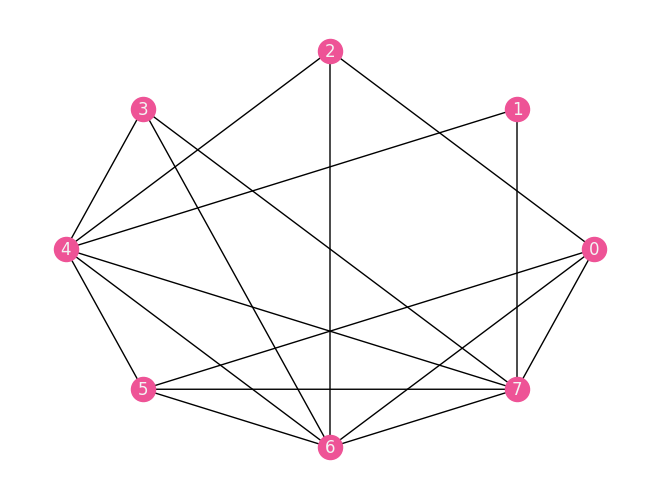

In [6]:
# Define the instance.
PROBLEM_DIM = 8
instance = 4
U, subsets_dict = define_instance(PROBLEM_DIM, instance, verbose=False)
subsets = list(subsets_dict.values())

# Build the graph.
list_of_intersections = build_instance_graph(subsets, verbose=False)

# Choose k.
k = 0.063

#### Set constants.

In [7]:
"""
The maximum number of controls needed in the circuit 
is equal to the maximum number of intersections, i.e. the
maximum number of edges coming out of a vertex.
"""
num_max_ctrl = max([len(l) for l in list_of_intersections])

NUM_ANC = num_max_ctrl - 1 # number of ancillas needed to use MCMTVChain
QC_DIM = PROBLEM_DIM + NUM_ANC # total number of qubits needed

print("num_max_ctrl", num_max_ctrl)
print("NUM_ANC", NUM_ANC)
print("PROBLEM_DIM", PROBLEM_DIM)
print("QC_DIM", QC_DIM)

num_max_ctrl 6
NUM_ANC 5
PROBLEM_DIM 8
QC_DIM 13


# Cost Hamiltonian

In [8]:
# !pip install more_itertools

In [9]:
# x = [elem for elem in distinct_permutations('IIZ', 3)]
# # print(x)

### Paper di Wang et al.:
The objective is to find the $minimum$ of:
$$ H_P = -\lambda_1\sum_i^n w_i\frac{1-Z_i}{2} +\lambda_2 \sum_i^n\frac{1-Z_i}{2} = $$
$$  =- \lambda_1\sum_i^n \frac{w_i}{2} +\lambda_1\sum_i^n \frac{w_iZ_i}{2} +\lambda_2 \sum_i^n\frac{1}{2} -\lambda_2 \sum_i^n\frac{Z_i}{2} = $$
$$  = -A + \lambda_1\sum_i^n \frac{w_iZ_i}{2} + B - \lambda_2 \sum_i^n\frac{Z_i}{2} = $$
$$  = -A +B +\sum_i^n \frac{\lambda_1w_i -\lambda_2}{2}Z_i  $$
where
$$ A =  \frac{\lambda_1}{2}\sum_i^n w_i      $$ 
$$     B = \frac{ n \lambda_2}{2}  $$

In [10]:
# z_op_on_first_qubit = 'Z'+'I'*(PROBLEM_DIM-1)
# labels = ['I'*NUM_ANC + ''.join(p) for p in distinct_permutations(z_op_on_first_qubit)]
# print(labels)


# Set the parameters.
l2 = 1/(PROBLEM_DIM * len(U) -2)
l1 = k * PROBLEM_DIM * l2 # l1/l2 must be equal to PROBLEM_DIM

A = l1 * sum([len(S) for S in subsets]) /2
B = l2 * PROBLEM_DIM /2

print("A =", A)
print("B =", B)
print("-A+B =", -A+B)


# Create Z operators.
coeffs = [(l1*len(S)/2 - l2/2) for S in subsets]
Z_operators = [("Z", [i], coeffs[i]) for i in range(PROBLEM_DIM)]
hamiltonian = SparsePauliOp.from_sparse_list(Z_operators, num_qubits=QC_DIM)

"""
Aggiungere la parte costante (-A+B) non serve a niente,
dato che farò una minimizzazione. 
"""
# # Add the -A+B term.
# constant_hamiltonian = SparsePauliOp.from_list([("I"*QC_DIM, -A+B)])
# hamiltonian = hamiltonian + constant_hamiltonian

"""Per tornare nel range di energia (0, -1], basterà
   calcolare E -A -B. 
                E ---> E -A -B
"""

print("\nhamiltonian:\n", hamiltonian)

A = 0.092
B = 0.031746031746031744
-A+B = -0.060253968253968254

hamiltonian:
 SparsePauliOp(['IIIIIIIIIIIIZ', 'IIIIIIIIIIIZI', 'IIIIIIIIIIZII', 'IIIIIIIIIZIII', 'IIIIIIIIZIIII', 'IIIIIIIZIIIII', 'IIIIIIZIIIIII', 'IIIIIZIIIIIII'],
              coeffs=[0.00603175+0.j, 0.00403175+0.j, 0.00403175+0.j, 0.00403175+0.j,
 0.01803175+0.j, 0.00403175+0.j, 0.01003175+0.j, 0.01003175+0.j])


### Creo un circuito per l'hamiltoniana (in realtà funziona anche senza renderla un circuito)

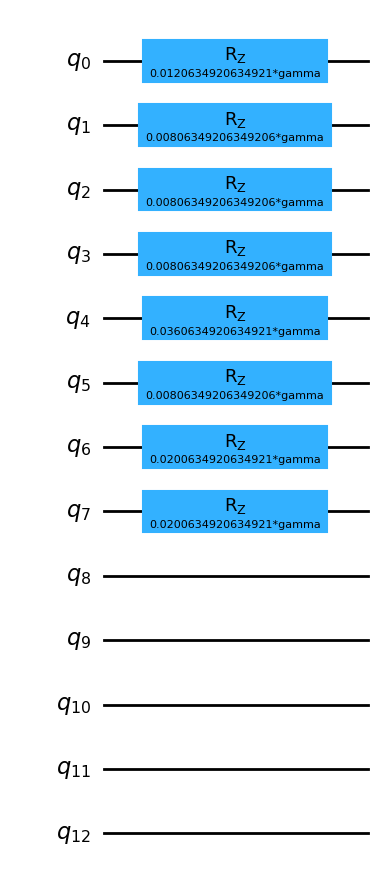

In [11]:
gamma = Parameter("gamma")
evo = PauliEvolutionGate(hamiltonian, time=gamma)
 
qc_ham = QuantumCircuit(QC_DIM)
qc_ham.append(evo, range(QC_DIM))

qc_ham = qc_ham.decompose(reps=2)
qc_ham.draw(output="mpl", style="iqp")

# Mixing Hamiltonian

### Creo la Mixing Hamiltonian aggiungendo al circuito le X-rotazioni controllate (i controlli sono le intersezioni)
Non servono più gli XGate perché ho cambiato il controllo a zero

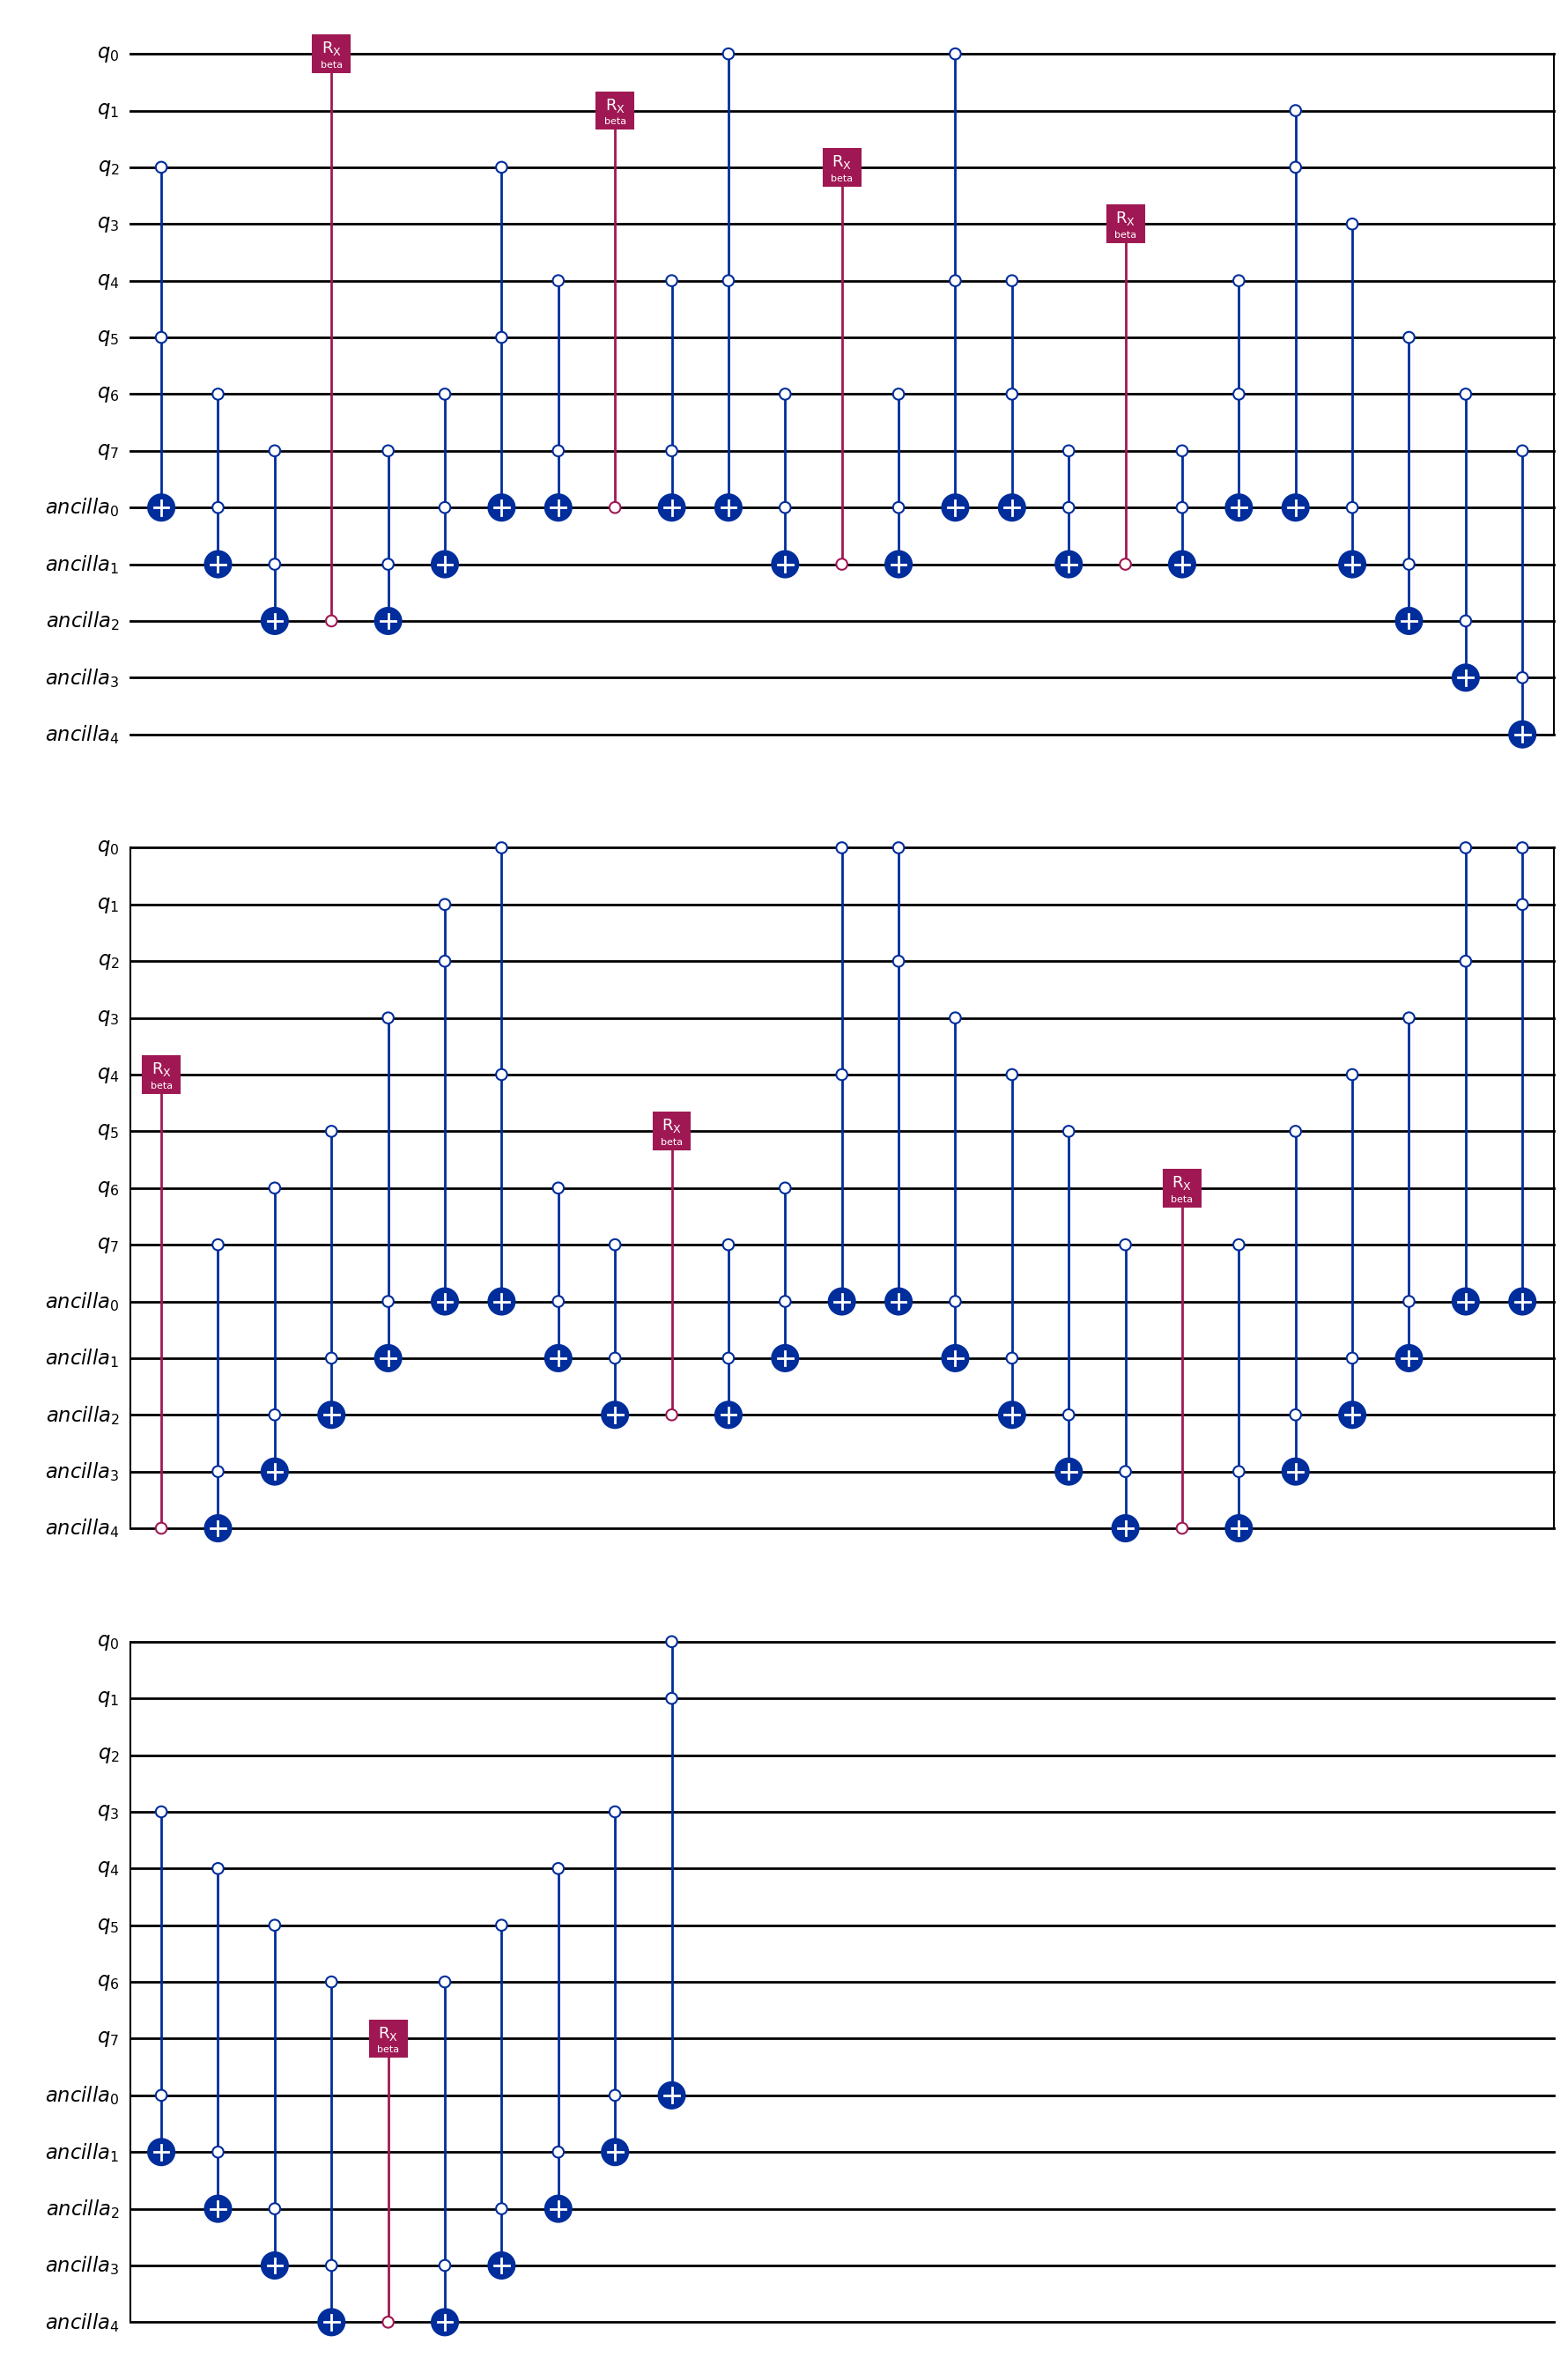

In [12]:
# Initialize the circuit.
qr = QuantumRegister(PROBLEM_DIM, 'q')
anc = QuantumRegister(NUM_ANC, 'ancilla')
qc_mixing = QuantumCircuit(qr, anc)

"""
Inizializzare le ancille a 1 a ogni strato del QAOA non serve,
basta inizializzarle una volta sola a p=1 perché su ogni ancilla agisce un 
numero pari di NOT-gate in ogni strato.
In realtà uno potrebbe inizializzarle in ogni strato per 
proteggersi da eventuali bit-flip.
"""
# # Initialize ancillas to 1.
# for ancilla in range(PROBLEM_DIM, QC_DIM):
#     qc_mixing.initialize(1, ancilla)

"""
Creo una lista di gate che (tramite VChain) implementano 
X-rotazioni con un diverso numero di controlli. L'elemento i
della lista avrà i+1 controlli.
"""
beta = Parameter('beta')
g = [MCMTVChain(RXGate(beta), x, 1) for x in range(1, num_max_ctrl+1)]
gates = [g[i].to_gate() for i in range(len(g))]

"""
Aggiungo al circuito i gate, specificando quali qubit
devono fare da controlli: ricorda che l'ordine giusto è 
[controlli, target, ancille] quindi se con 5 qubit [0,1,2,3,4] 
e 2 ancille [5,6] voglio fare una rotazione X su 1 
controllata da 0, 2, 3 scriverò:

qc_mixing.append(gates[2], [0,2,3, 1, 5,6])
"""
for i, intersections in enumerate(list_of_intersections):
    n = len(intersections)
    qubits_list = intersections + [i] + list(range(PROBLEM_DIM, PROBLEM_DIM+n-1))       
    qc_mixing.append(gates[n-1], qubits_list)

qc_mixing.decompose().draw('mpl')

# Whole QAOA circuit

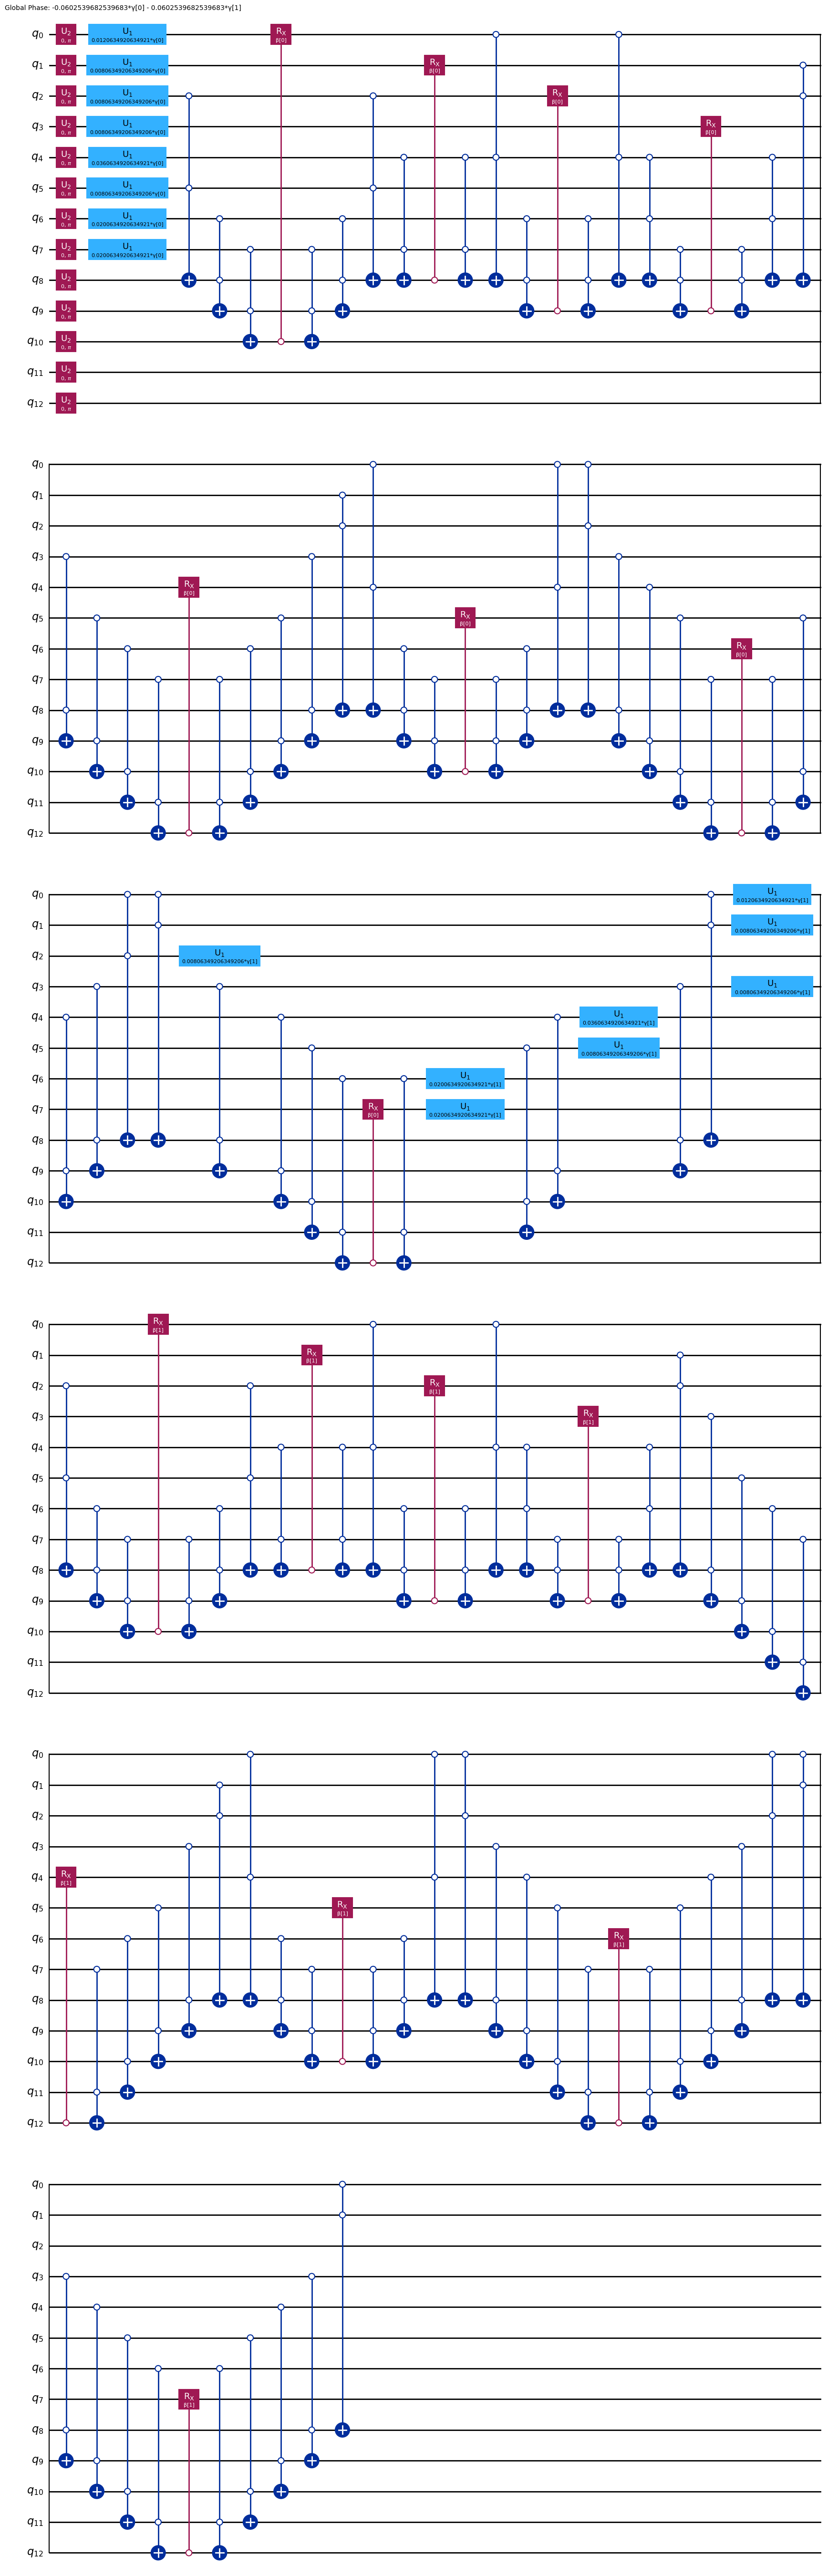

In [13]:
ansatz = QAOAAnsatz(qc_ham, mixer_operator=qc_mixing, initial_state=None, reps=2, name='my_QAOA_circuit')
ansatz.decompose(reps=2).draw('mpl')

# Look at the energy landscape:

In [14]:
string = '0'*(PROBLEM_DIM-1) + '1'
one_one_states = ["".join(elem) for elem in distinct_permutations(string)]
print(one_one_states)

['00000001', '00000010', '00000100', '00001000', '00010000', '00100000', '01000000', '10000000']


#### Faccio il plot dell'energia solo per gli stati feasible: mi aspetto una funzione compresa tra 0 e -1 se k=1.

In [15]:
states, energies, states_feasible, energies_feasible, EXACT_COVERS = find_spectrum(U, subsets_dict, PROBLEM_DIM, k)
MEC = [state for state in EXACT_COVERS if state.count("1") == min([x.count("1")  for x in EXACT_COVERS])]

print("EXACT_COVERS:", EXACT_COVERS)
print("MEC:", MEC)

EXACT_COVERS: ['01110100', '10001000']
MEC: ['10001000']


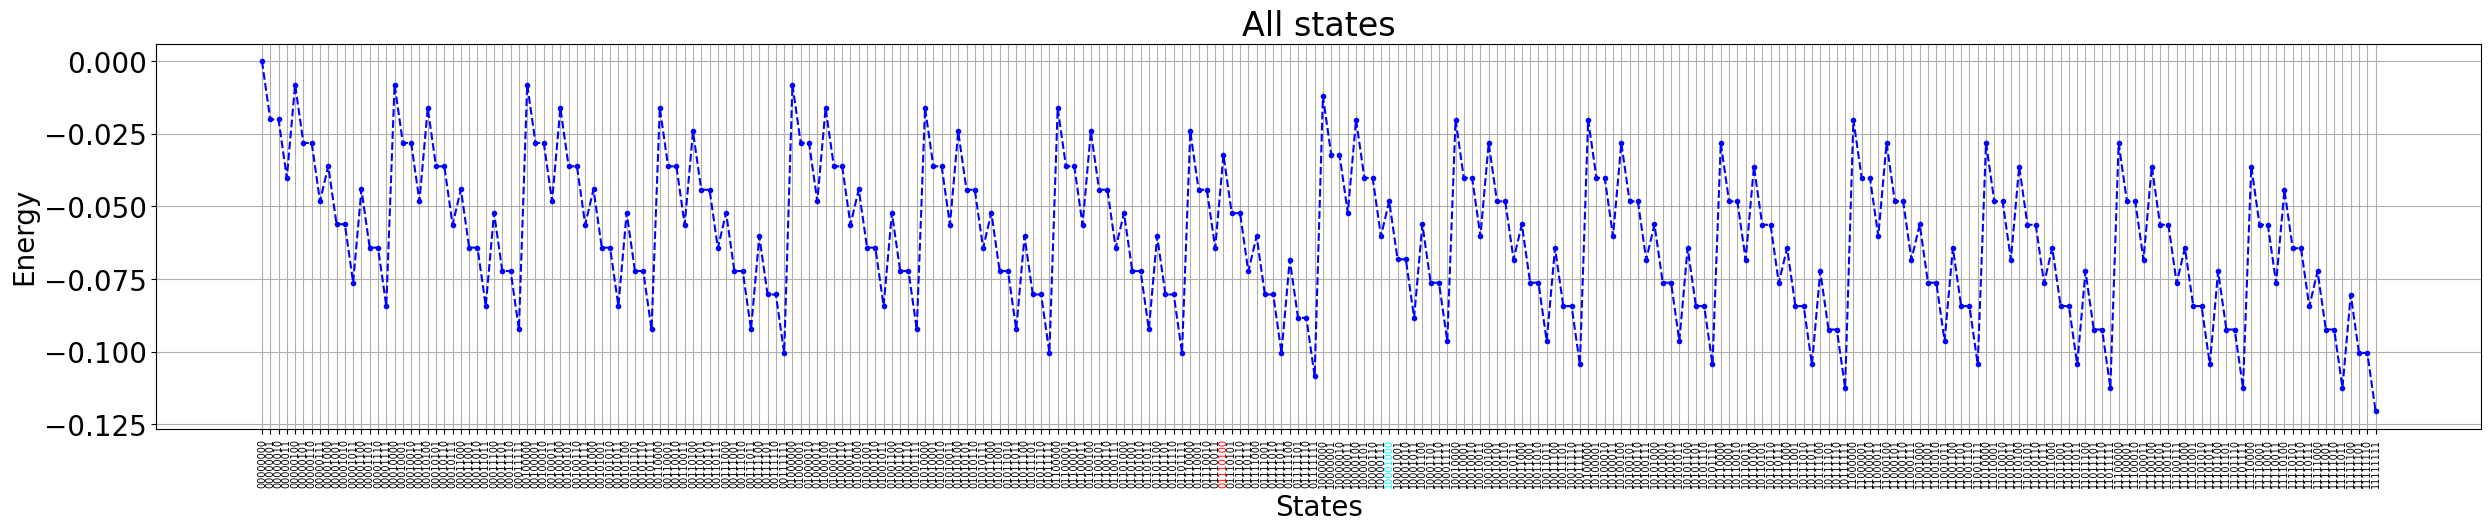

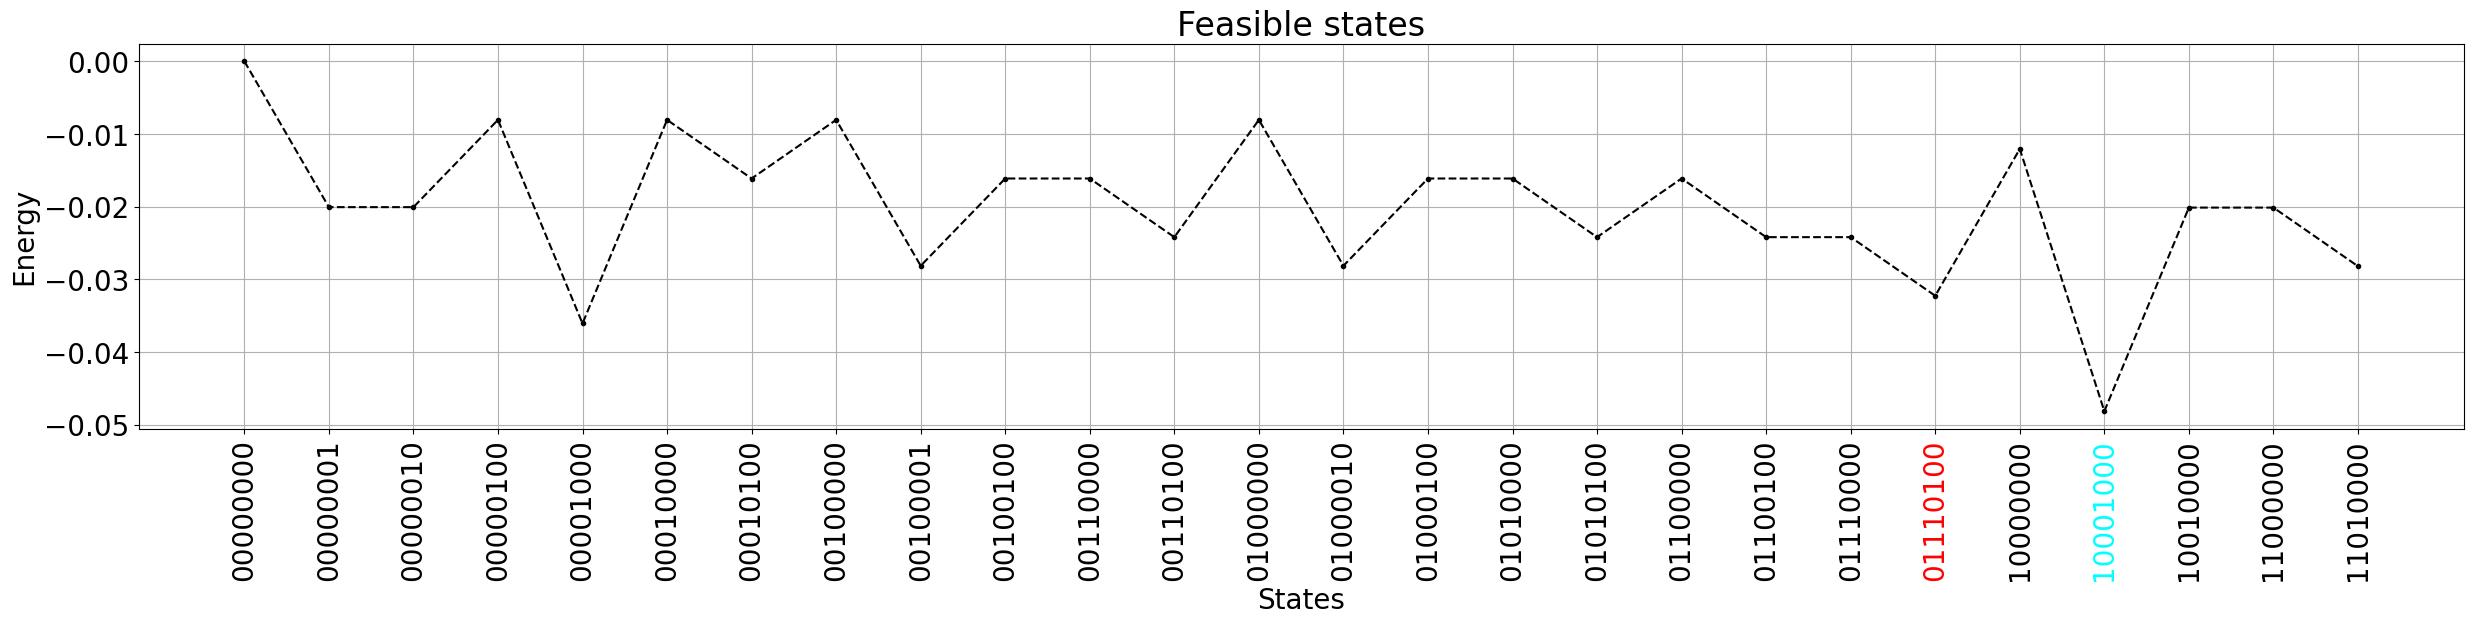

In [16]:
#### PLOT ALL STATES ENERGY
dim = 20
plt.figure(figsize=(30,5))
plt.rcParams['font.size'] = dim
plt.title("All states")
plt.plot(states, energies, '.--b')
plt.xticks(rotation='vertical', fontsize=7)
plt.xlabel("States")
plt.ylabel("Energy")
# plt.ylim(-3,0)
plt.grid()

# Highlight with red the exact covers
highlight_correct_ticks(plt.gca(), states, EXACT_COVERS)

plt.show()


#### PLOT THE FEASIBLE STATES ENERGIES.
dim = 20
plt.figure(figsize=(30,5))
plt.rcParams['font.size'] = dim
plt.title("Feasible states")
plt.plot(states_feasible, energies_feasible, '.--k')
plt.xticks(rotation='vertical', fontsize=dim)
plt.xlabel("States")
plt.ylabel("Energy")
# plt.ylim(-3,0)
plt.grid()

# Highlight with red the exact covers
highlight_correct_ticks(plt.gca(), states_feasible, EXACT_COVERS)

plt.show()

# Initialization

In [17]:
def initialize_circuit(init_name):
    """
    Initialize with all0 or all1.
    
    Parameters
    ----------
        init_name (str): name of the initialization, e.g. "all1" or "all0"
    Return
    ------
        q_initial (QuantumCircuit): circuit with the correct initialization
    """
    
    ##### CIRCUIT #####
    qr = QuantumRegister(PROBLEM_DIM, 'q')
    anc = QuantumRegister(NUM_ANC, 'ancilla')
    q_initial = QuantumCircuit(qr, anc)
    
    
    ##### ANCILLAS #####
    #Initialize ancillas to 1.
    for ancilla in range(PROBLEM_DIM, QC_DIM):
        q_initial.initialize(1, ancilla)
    
    
    ##### QUBITS #####
    
    #### SCELGO GLI STATI CON CUI CREARE LA SOVRAPPOSIZIONE.
    #### RICORDA CHE DEVONO SODDISFARE IL VINCOLO, OVVERO DEVO
    #### SELEZIONARE INSIEMI CHE NON SI INTERSECANO
    # string = '0'*(PROBLEM_DIM-2) + '11'
    # two_one_states = set(["".join(elem) for elem in distinct_permutations(string)])
    # print(two_one_states)
    # init_state = two_one_states + one_one_states
    # init_state = [EC]  + one_one_states

    if init_name == "all1":
        init_state =  one_one_states
    
    if init_name == "all0": 
        init_state = ["0"*PROBLEM_DIM]
    
    
    print("init_state:\n", init_state, "\ninit_name:", init_name)
    init_state = [x[::-1] for x in init_state] # reverse their order
    # occurrences = [1454, 1353, 37, 36, 34] # found on Leap
    
    
    #### SCELGO I PESI PER LA SOVRAPPOSIZIONE E GLI ASSEGNO AGLI STATI, 
    #### USANDO UN VETTORE DI LUNGHEZZA 2**PROBLEM_DIM.
    # init_state = np.sqrt(1/len(init_state)) * np.ones(len(init_state)) # equal superposition
    # print(init_state)
    
    vec = np.zeros(2**PROBLEM_DIM) # has length 2**PROBLEM_DIM
    j = 0
    for i,nuple in enumerate(bit_gen(PROBLEM_DIM)):
        state = "".join([str(bit) for bit in nuple]) # strings
        if state in init_state:
            vec[i] = 1
            j = j+1
    
    
    #### TRASFORMO IN STATEVECTOR IL VETTORE SCELTO ####
    state = Statevector(vec)
    q_initial.initialize(state.data, list(range(PROBLEM_DIM)), normalize=True) # set it as initial state for the first PROBLEM_DIM qubits
    
    
    ##### MISURO PER CONTROLLARE CHE LA SOVRAPPOSIZIONE SIA CORRETTA #####
    ##### commenta per usare la sovrapposizione nel seguito! #####
    # q_initial.measure_all()
    
    # # Let's see the result
    # svsim = Aer.get_backend('aer_simulator')
    # q_initial.save_statevector()
    # result = svsim.run(q_initial).result()
    
    # # Print the statevector neatly:
    # final_state = result.get_statevector()
    # plot_histogram(result.get_counts())
    
    # # from qiskit.visualization import plot_state_qsphere
    # # array_to_latex(final_state, prefix="\\text{Statevector = }")
    # # plot_state_qsphere(state)

    return q_initial

See how a p=1 depth circuit looks like:

In [18]:
# ansatz = QAOAAnsatz(qc_ham, mixer_operator=qc_mixing, initial_state=q_initial, reps=2, name='my_QAOA_circuit')
# ansatz.decompose(reps=2).draw('mpl')

- For the first layer (p=1): choose two random initial parameters [beta[0], gamma[0]] and find, minimizing cost_func, two optimal parameters [BETA[0], GAMMA[0]].
- For the second layer (p=2): append two random initial parameters to the optimal parameters already found [BETA[0], beta[1], GAMMA[0], gamma[1]] and find, minimizing cost_func, *two* new optimal parameters that you will append to the optimal parameters already found for the previous layer [BETA[0], BETA[1], GAMMA[0], GAMMA[1]].
- And so on...

Risultato se lo stato iniziale è:
- una sovrapposizione di exact covers ->  rimane tale

# Minimization

### Random parameters

##### Parameters to set

In [27]:
p = 3
random_attempts = 10
init_name = "all0"

In [28]:
beta_0 = (0, 2*np.pi)
gamma_0 = (-1000, 1000)
string_0 = "[0,2pi]x[-1000,1000]"

bnds_beta = (0, 2*np.pi)
bnds_gamma = (None, None)
bnds_string = "[0,2pi]x[None,None]"

##### Build filename & minimization

In [29]:
# current_datetime = datetime.now().strftime("@%Y-%m-%d@%Hh%Mm%Ss")
current_datetime = datetime.now().strftime("%d-%m@%Hh%Mm")


# This file will contain the final histograms.
header = f"{current_datetime}_dim{PROBLEM_DIM}_mail{instance}_{init_name}_random_p{p}_{random_attempts}ra_k{k}_BOUNDS{bnds_string}_pars0{string_0}"

# This file will contain important data such as energies, betas, gammas.
from ast import literal_eval
DATA_FILENAME = header + '_data.txt'
FILENAME = header + ".csv"

print(FILENAME, "\n", DATA_FILENAME)

17-09@19h10m_dim8_mail4_all0_random_p3_10ra_k0.063_BOUNDS[0,2pi]x[None,None]_pars0[0,2pi]x[-1000,1000].csv 
 17-09@19h10m_dim8_mail4_all0_random_p3_10ra_k0.063_BOUNDS[0,2pi]x[None,None]_pars0[0,2pi]x[-1000,1000]_data.txt


init_state:
 ['00000000'] 
init_name: all0
Initial parameters (for the minimization): pars_0 =  [5.364482541421466, 5.614564352284347, 3.809486905519525, 318.03257200829626, 992.1098436051857, 345.5795442827441]
Final parameters (after minimization): betas, gammas = [6.283185307179586, 6.283185304994708, 3.141592597041922], [353.38912723333493, 1024.8849567568773, 236.45524155455402]
E_min = res.fun - A - B = -0.09168253968254195
E_min's parameters: betas, gammas =  [6.283185307179586, 6.283185304994708, 3.141592597041922] [353.38912723333493, 1024.8849567568773, 236.45524155455402]
***UPDATING***


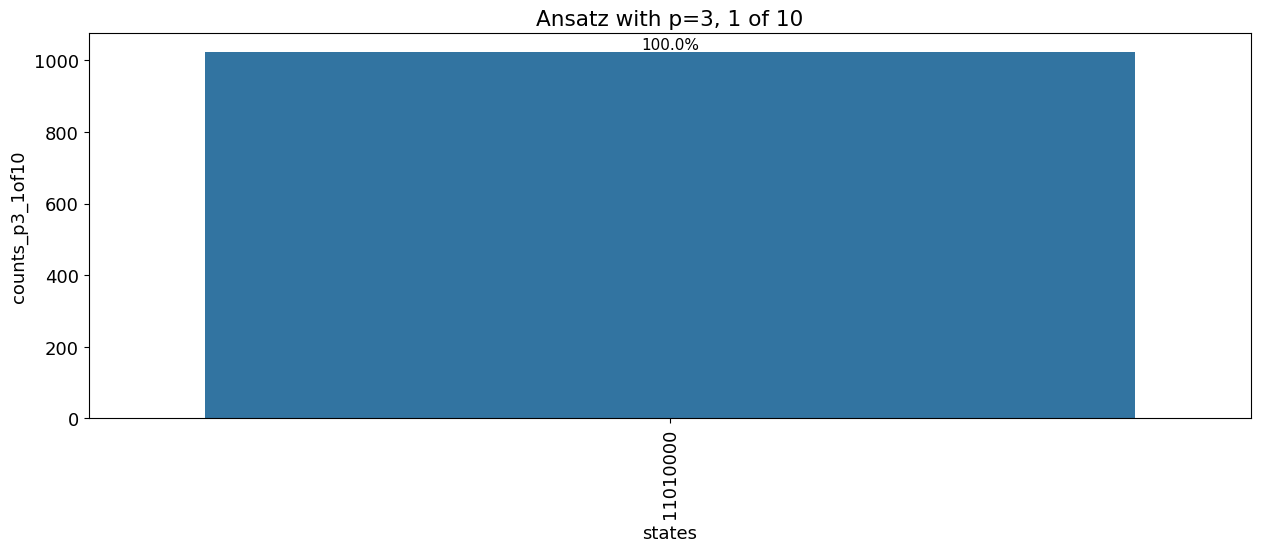

init_state:
 ['00000000'] 
init_name: all0
Initial parameters (for the minimization): pars_0 =  [5.509477800432499, 0.9984220848090409, 2.537247763662118, -942.6477803014692, -159.55082090709527, -913.0723678073105]
Final parameters (after minimization): betas, gammas = [6.283185307179577, 1.5763748108505498, 1.515278946743659], [-1414.574474016145, -146.8397962806518, -781.3558577463195]
E_min = res.fun - A - B = -0.09341786532734538
E_min's parameters: betas, gammas =  [6.283185307179577, 1.5763748108505498, 1.515278946743659] [-1414.574474016145, -146.8397962806518, -781.3558577463195]
***UPDATING***


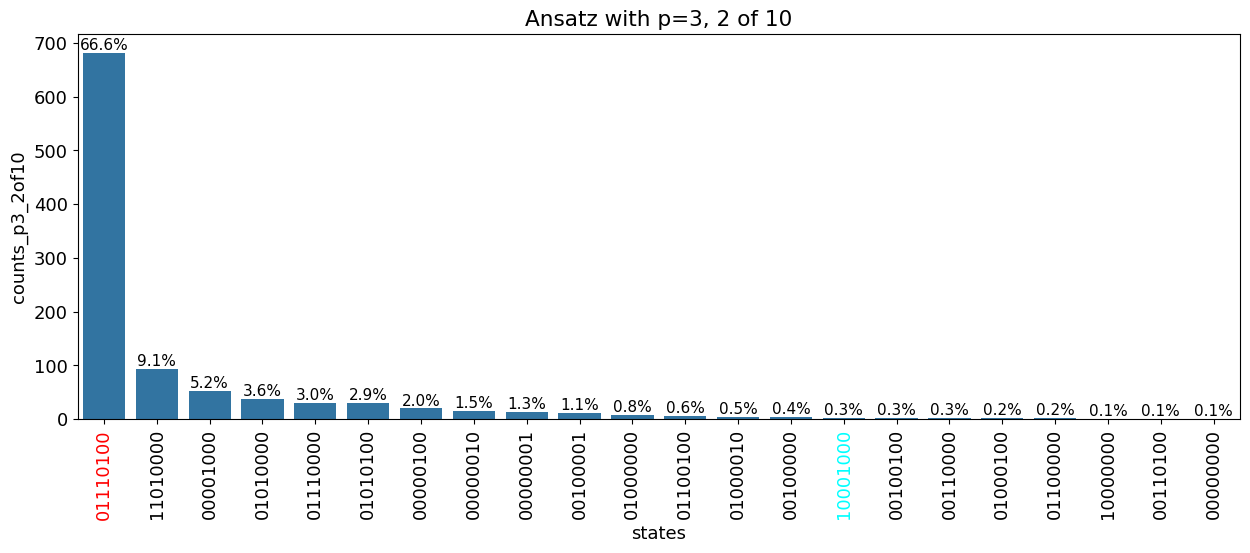

init_state:
 ['00000000'] 
init_name: all0
Initial parameters (for the minimization): pars_0 =  [1.7561315224071916, 3.282650453477421, 1.2617436229640762, 837.8396486125753, 471.69065705391336, -722.4501588366586]
Final parameters (after minimization): betas, gammas = [1.0238027829877798, 1.8688410605078578, 0.8575892049813566], [758.5837070328917, 339.5390513226921, -956.8842349144586]
E_min = res.fun - A - B = -0.09469322804188122
E_min's parameters: betas, gammas =  [1.0238027829877798, 1.8688410605078578, 0.8575892049813566] [758.5837070328917, 339.5390513226921, -956.8842349144586]
***UPDATING***


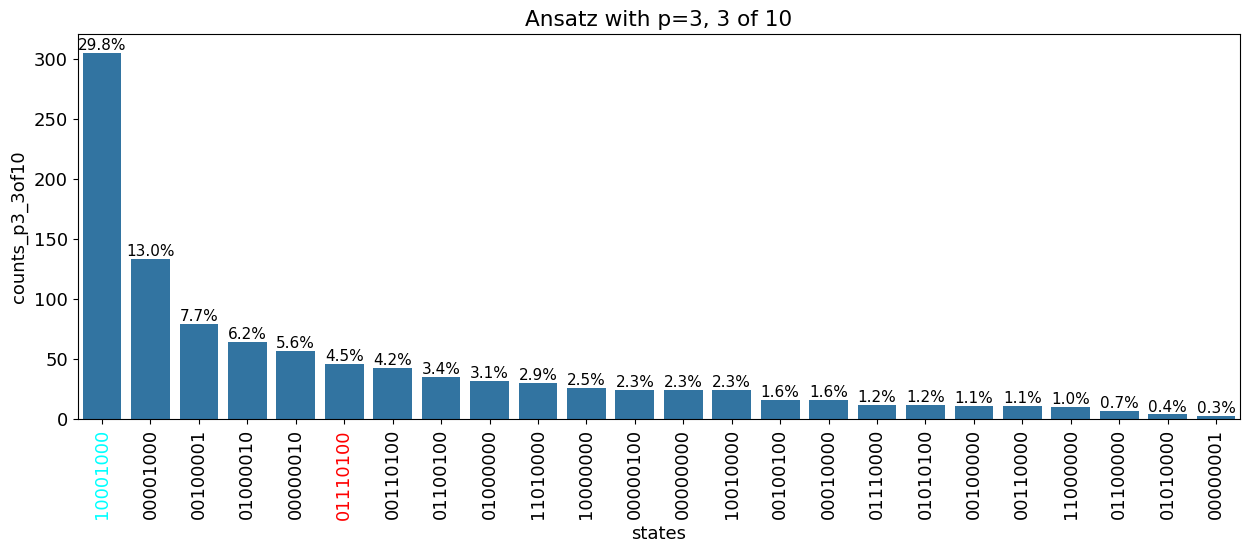

init_state:
 ['00000000'] 
init_name: all0
Initial parameters (for the minimization): pars_0 =  [2.7251457936186116, 3.9058750417826023, 3.2970763325276886, 824.8193311608638, 993.7581047374799, 901.3806774001048]
Final parameters (after minimization): betas, gammas = [1.58097844741555, 5.15199003995209, 2.4728879945282216], [397.8005848246705, 1100.9904217943445, 946.7425844788656]
E_min = res.fun - A - B = -0.09684773785703657
E_min's parameters: betas, gammas =  [1.58097844741555, 5.15199003995209, 2.4728879945282216] [397.8005848246705, 1100.9904217943445, 946.7425844788656]
***UPDATING***


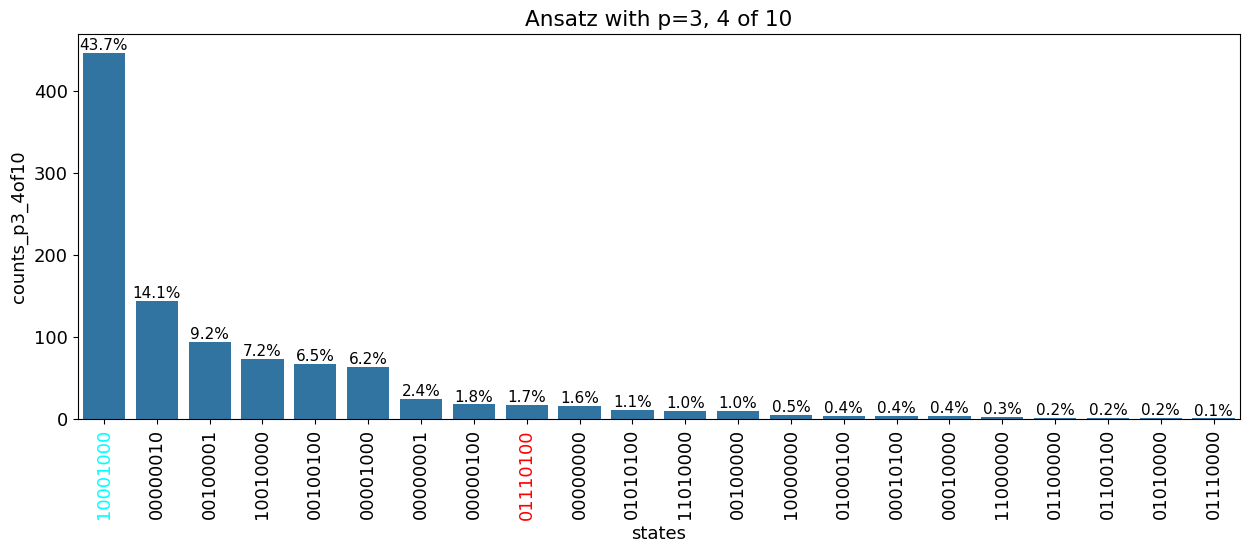

init_state:
 ['00000000'] 
init_name: all0
Initial parameters (for the minimization): pars_0 =  [6.261677083082549, 0.5238474872158922, 3.1092469415658, 743.9027672648415, -51.3720613696604, 607.5685158149754]
Final parameters (after minimization): betas, gammas = [6.283185307179586, 2.2691431371510725e-08, 3.1415926594295485], [1021.6437335160332, -72.56601849848366, 933.0980873631755]
E_min = res.fun - A - B = -0.091682539682542
E_min's parameters: betas, gammas =  [6.283185307179586, 2.2691431371510725e-08, 3.1415926594295485] [1021.6437335160332, -72.56601849848366, 933.0980873631755]


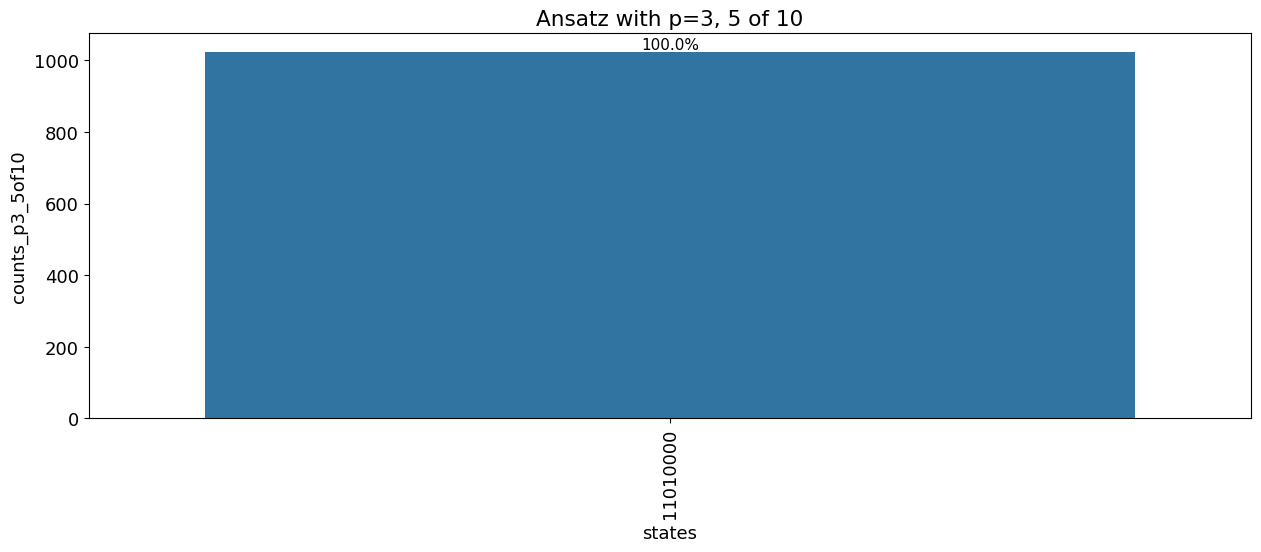

init_state:
 ['00000000'] 
init_name: all0
Initial parameters (for the minimization): pars_0 =  [0.9704445946631026, 2.8599072739637457, 2.9707880666001714, 82.37913936510063, 538.7563525354105, 800.7629785989429]
Final parameters (after minimization): betas, gammas = [0.46458242360279467, 1.260760944349562, 4.799061948109674], [99.13061917346721, 507.3452351959295, 794.205404547209]
E_min = res.fun - A - B = -0.1026984716188856
E_min's parameters: betas, gammas =  [0.46458242360279467, 1.260760944349562, 4.799061948109674] [99.13061917346721, 507.3452351959295, 794.205404547209]
***UPDATING***


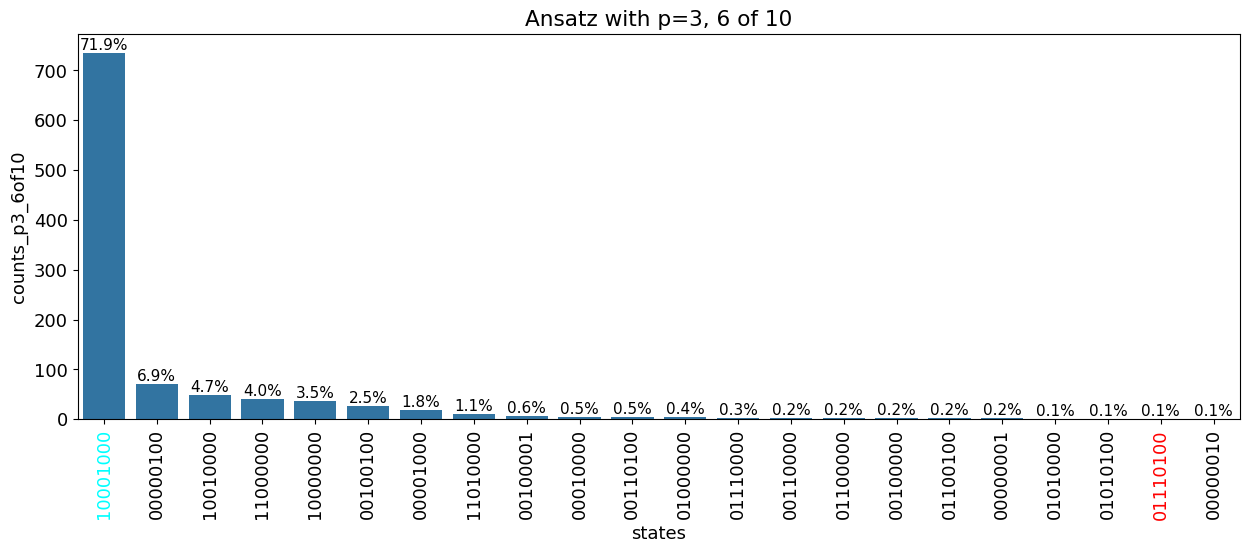

init_state:
 ['00000000'] 
init_name: all0
Initial parameters (for the minimization): pars_0 =  [5.913048832578614, 1.3486784379425192, 3.1685084719595356, -979.365598875585, -229.0339238410612, 260.18472750912747]
Final parameters (after minimization): betas, gammas = [6.283185284331868, 1.4400779459199485e-08, 3.141592626414747], [-627.2898576796293, -359.55827325756024, 389.28900965700143]
E_min = res.fun - A - B = -0.09168253968254195
E_min's parameters: betas, gammas =  [6.283185284331868, 1.4400779459199485e-08, 3.141592626414747] [-627.2898576796293, -359.55827325756024, 389.28900965700143]


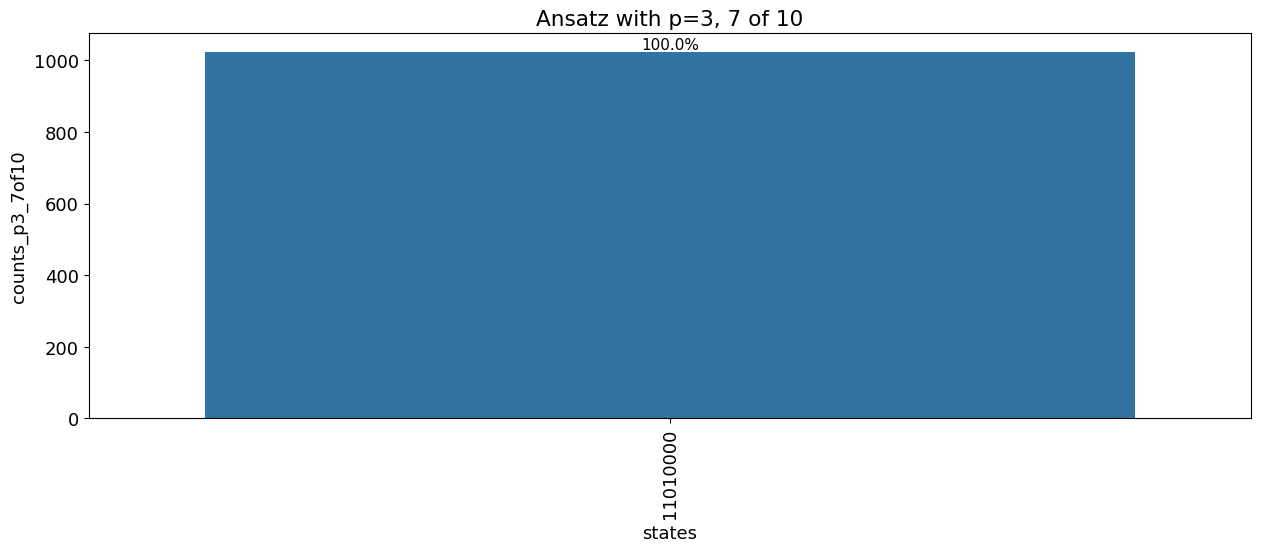

init_state:
 ['00000000'] 
init_name: all0
Initial parameters (for the minimization): pars_0 =  [2.4542596496144364, 2.846261991834738, 4.96198903001711, -319.98938087906276, -593.4648244963525, -531.796022424865]
Final parameters (after minimization): betas, gammas = [1.4590924872364013, 1.7505455821112514, 5.550489900283305], [-402.26532144404166, -545.5052669992633, -667.8427209109586]
E_min = res.fun - A - B = -0.09229842910113295
E_min's parameters: betas, gammas =  [1.4590924872364013, 1.7505455821112514, 5.550489900283305] [-402.26532144404166, -545.5052669992633, -667.8427209109586]


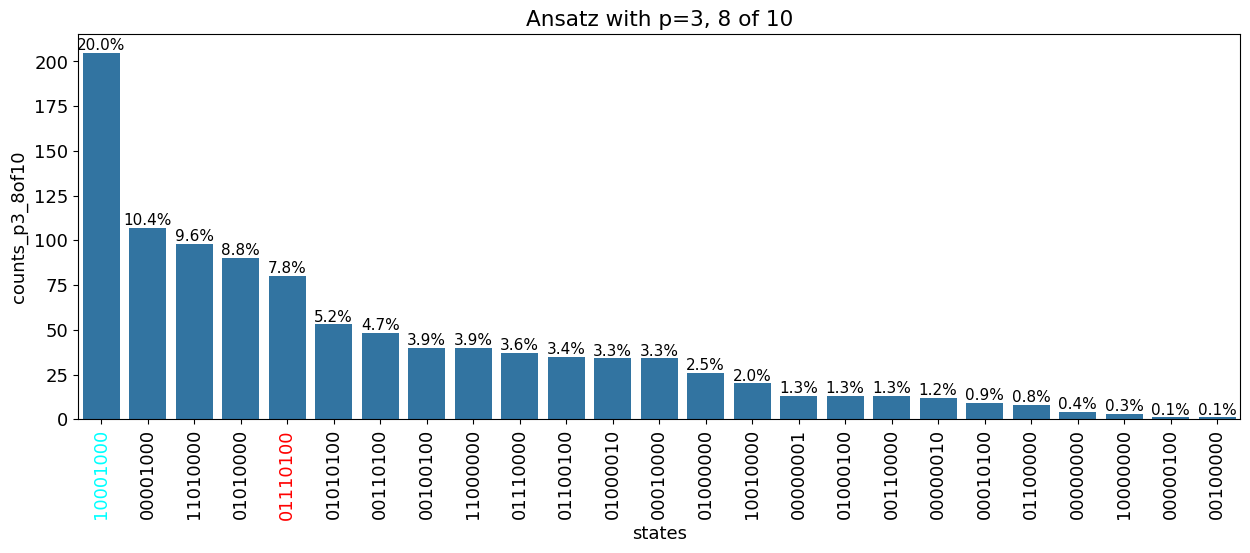

init_state:
 ['00000000'] 
init_name: all0
Initial parameters (for the minimization): pars_0 =  [5.344373998990315, 1.5183869476331375, 3.28000252363944, -29.90000798967435, 344.58853013018006, 239.74527719281832]
Final parameters (after minimization): betas, gammas = [3.9022851205407205, 0.9565310787943793, 1.894868459554385], [-37.09742541352807, 657.0929793299556, 234.37928646969857]
E_min = res.fun - A - B = -0.09127927697013774
E_min's parameters: betas, gammas =  [3.9022851205407205, 0.9565310787943793, 1.894868459554385] [-37.09742541352807, 657.0929793299556, 234.37928646969857]


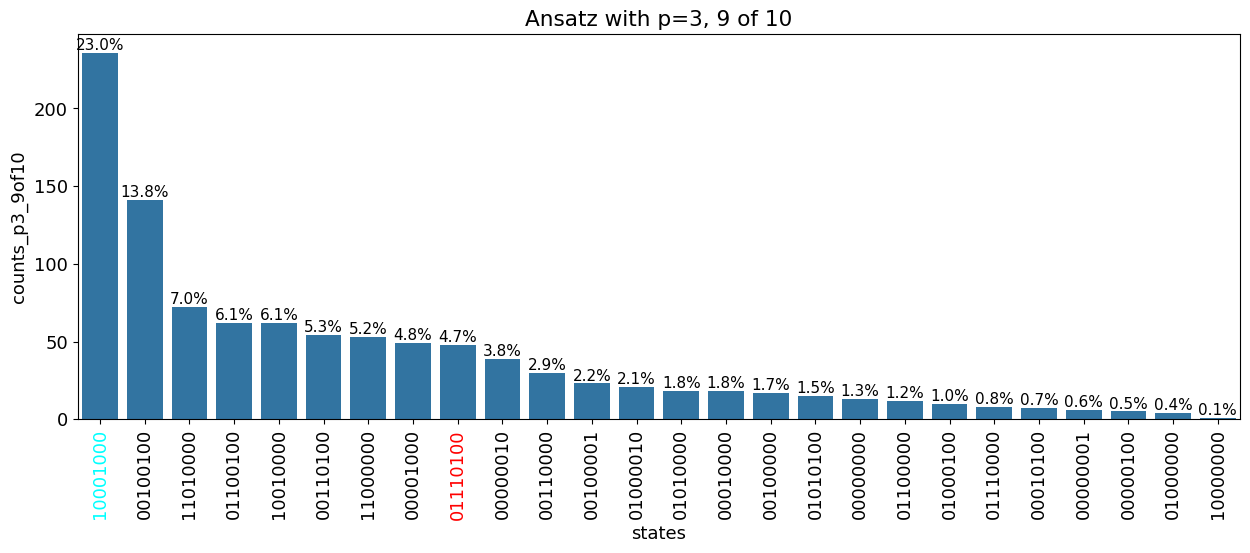

init_state:
 ['00000000'] 
init_name: all0
Initial parameters (for the minimization): pars_0 =  [5.698493430852383, 5.812267237932527, 1.0000688717251234, -309.7870552158688, -871.3162396340481, -858.926532967025]
Final parameters (after minimization): betas, gammas = [5.891215568219442, 5.840720424666417, 1.6114991510512566], [-161.62077418296664, -851.3039932825575, -890.1473968046674]
E_min = res.fun - A - B = -0.08949966543192157
E_min's parameters: betas, gammas =  [5.891215568219442, 5.840720424666417, 1.6114991510512566] [-161.62077418296664, -851.3039932825575, -890.1473968046674]


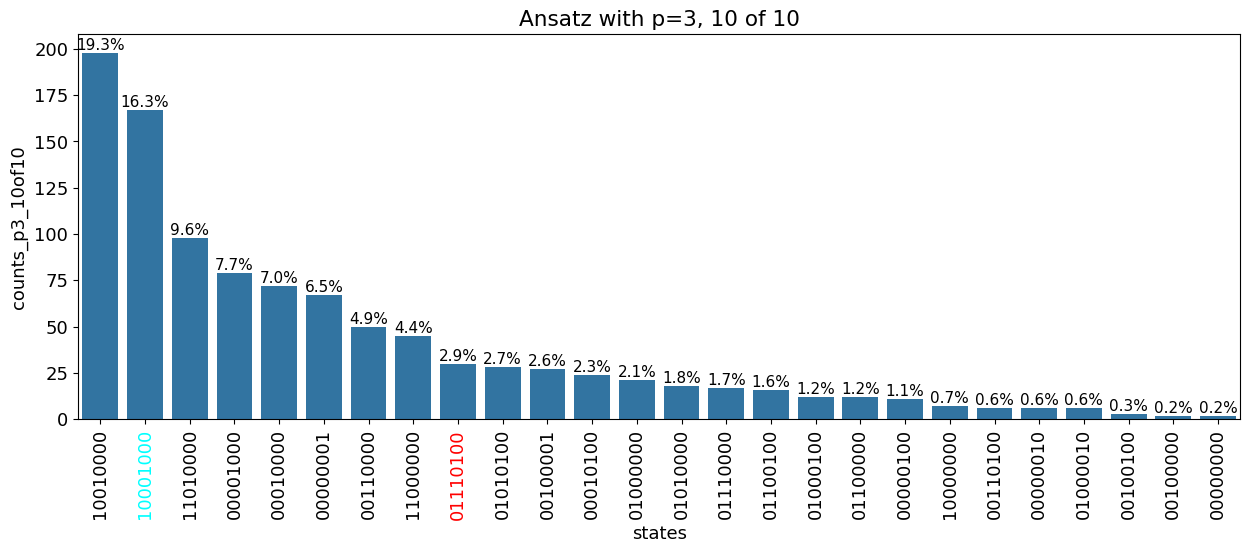


TOTAL ELAPSED TIME: 12.74661990404129 minutes.
17-09@19h10m_dim8_mail4_all0_random_p3_10ra_k0.063_BOUNDS[0,2pi]x[None,None]_pars0[0,2pi]x[-1000,1000].csv [5.698493430852383, 5.812267237932527, 1.0000688717251234, -309.7870552158688, -871.3162396340481, -858.926532967025] [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (None, None), (None, None), (None, None)]


In [30]:
with open(DATA_FILENAME, 'a') as DATA_FILE:
    # DATA_FILE.write(f"The initial state is an equal superposition of: {init_state} \n")
    
    DATA_FILE.write(f"p={p}\n")

    E_best = 100
    counter = 0
    TOTAL_start_time = time.time()

    for i in range(1,random_attempts+1):
        DATA_FILE.write(f"\n----- {i}/{random_attempts} random_attempts -----\n")
        ansatz = QAOAAnsatz(qc_ham, mixer_operator=qc_mixing, initial_state=initialize_circuit(init_name), reps=p, name='my_QAOA_circuit')
                
        # Generate a pass manager without providing a backend
        pm = generate_preset_pass_manager(optimization_level=3)
        ansatz_isa = pm.run(ansatz)
        hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
    
        estimator = StatevectorEstimator()
        sampler = StatevectorSampler()
    
        
        # *******************************  MINIMIZE  **********************************
        # # Do the minimization.
        pars_0 = [random.uniform(*beta_0) for _ in range(p)] + [random.uniform(*gamma_0) for _ in range(p)]
        
        print('Initial parameters (for the minimization): pars_0 = ', pars_0)

        
        bnds = [bnds_beta]*p + [bnds_gamma]*p
        res = minimize(cost_func, pars_0, bounds=bnds,
                       args=(ansatz_isa, hamiltonian_isa, estimator), 
                       method="Nelder-Mead", options={"maxiter": 1000}, tol=1e-4)
    
        
        # Select the optimal parameters [beta,gamma] found.
        betas = list(res.x[:p])
        gammas = list(res.x[p:])
        print(f"Final parameters (after minimization): betas, gammas = {betas}, {gammas}")
    
        E_min = res.fun -A -B    
        print(f"E_min = res.fun - A - B = {E_min}")
        DATA_FILE.write(f"\nE_min = {E_min}")

        print(f'E_min\'s parameters: betas, gammas = ', betas, gammas)
        DATA_FILE.write(f'\nE_min\'s parameters: betas = {betas}, gammas = {gammas}\n')

        if E_min < E_best:
                E_best = E_min
                i_best = i 
                print("***UPDATING***")
    
                
        # ****************************  RUN THE CIRCUIT  ******************************
        # Assign to the ansatz the 2p parameters found, then run the circuit.
        pars = betas + gammas
        qc = ansatz.assign_parameters(pars)
        qc.measure_all()
        qc_isa = pm.run(qc)
        result = sampler.run([qc_isa], shots=1024).result()
        samp_dist = result[0].data.meas.get_counts()

        ##########################################################à
    
        
        # ****************************  POST PROCESS  **********************************
        # Create a dataframe out of the sampling's results.
        df = pd.DataFrame(samp_dist.items()).rename(columns={0: 'states', 1: 'counts'})
        df['states'] = df['states'].apply(lambda x: x[NUM_ANC:]) # remove ancillary bits
        df = df.groupby(['states']).sum()
        
        # Create a dictionary with states and occurrences.
        d = df['counts'].to_dict()
        lists = sorted(d.items(), key=lambda item: item[1], reverse=True)
    
        # Invert bit order ("01101 -> 10110")      
        d = invert_counts(d)
    
    
        # **************************** PLOT THE i-TH DATAFRAME ****************************
        plt.figure(figsize=(15,5))
        plt.rcParams['font.size'] = 13
        plt.title(f"Ansatz with p={p}, {i} of {random_attempts}")
        df = pd.DataFrame(d.items())
        df = df.rename(columns={0: 'states', 1: f'counts_p{p}_{i}of{random_attempts}'})    
        df = df.sort_values(f'counts_p{p}_{i}of{random_attempts}', ascending=False) 
        
        ax = sns.barplot(x='states', y=f'counts_p{p}_{i}of{random_attempts}', data=df)
        
        # Make labels with percentages.
        labels = df[f'counts_p{p}_{i}of{random_attempts}'].apply(lambda x: (x/df[f'counts_p{p}_{i}of{random_attempts}'].sum())*100).round(1).astype('str') + '%'
        for container in ax.containers:
            ax.bar_label(container, labels=labels, fontsize=11)
            
        # Highlight with red the exact covers
        highlight_correct_ticks(ax, list(df["states"]), EXACT_COVERS)
        plt.show()

        # Merge dataframes.
        if i == 1:
            df_final = df
        else:
            df_final = pd.merge(df_final, df, on="states", how="outer")    

        if df['states'].iloc[0] == MEC:    
            DATA_FILE.write("\n### Most frequent state is MEC ###\n")
            counter += 1
    
    # ################### SAVE TO CSV AND FIX BETA,GAMMA ###################
    # Save to csv.
    df_final.to_csv(FILENAME, index=False)

    ######################################################################
    DATA_FILE.write("\n*******************************")
    DATA_FILE.write(f"\nAttempt that reached the best result with E_min = {E_best} is #{i_best} ")
    DATA_FILE.write(f"\nMost frequent state was MEC / random attempts = {counter} / {random_attempts} = {round((counter/random_attempts)*100, 1)}%\n")
    

    print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")
    DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.\n")
    print(FILENAME, pars_0, bnds)

In [31]:
print(FILENAME, pars_0, bnds)

17-09@19h10m_dim8_mail4_all0_random_p3_10ra_k0.063_BOUNDS[0,2pi]x[None,None]_pars0[0,2pi]x[-1000,1000].csv [5.698493430852383, 5.812267237932527, 1.0000688717251234, -309.7870552158688, -871.3162396340481, -858.926532967025] [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (None, None), (None, None), (None, None)]


### Random parameters (read from file)

##### Change the filename and the directory:

In [32]:
# # directory = "uMAIL3_DIM6_settembre/random/"
# directory = ""
# header = "16-09@11h50m_dim6_mail5_all1_random_p3_10ra_k1_BOUNDS[0,2pi]x[None,None]_pars0[0,2pi]x[-1000,1000]"

# DATA_FILENAME = directory + header +"_data.txt"
# FILENAME = DATA_FILENAME.split("_data")[0] + ".csv"
# print(FILENAME)

In [33]:
##### EXTRAPOLATE INFORMATION FROM THE FILENAME
PROBLEM_DIM, instance, init_name, p, random_attempts, k = define_parameters_from_filename(DATA_FILENAME)
print(PROBLEM_DIM, instance, init_name, p, random_attempts, k)

##### WITH THIS INFORMATION, GET THE INSTANCE SETS
U, subsets_dict = define_instance(PROBLEM_DIM, instance, verbose=False)

##### FIND FEASIBLE STATES, ENERGIES, EXACT COVERS
states, energies, states_feasible, energies_feasible, EXACT_COVERS = find_spectrum(U, subsets_dict, PROBLEM_DIM, k)
print("\nEXACT_COVERS: ", EXACT_COVERS)

8 4 all0 3 10 0.063

EXACT_COVERS:  ['01110100', '10001000']


string 6 

i_best is 6


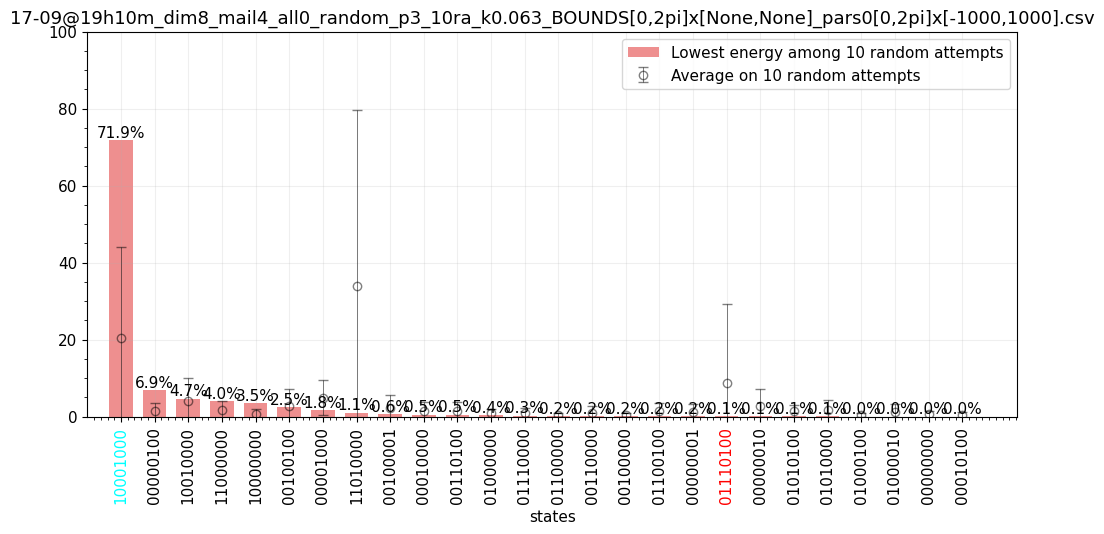

In [34]:
##### UPLOAD THE DATAFRAME FROM FILE
df = pd.read_csv(FILENAME, dtype = str).set_index('states')
df = df.astype(float).fillna(0.0)


##### COMPUTE PERCENTAGES AND ADD AVERAGE COLUMN
total = df.sum()
percentage = (df/ total) * 100


percentage['average'] = percentage.mean(numeric_only=True, axis=1)
percentage['std'] = percentage[percentage.columns[:-1]].std(numeric_only=True, axis=1)

##### FIND THE BEST HISTOGRAM INDEX (i_best) BASED ON THE MINIMUM ENERGY FOUND
with open(DATA_FILENAME, 'r') as DATA_FILE:
    for line in DATA_FILE:
        if 'Attempt that reached the best result with' in line:                
            string = line.split('#')[1]
            i_best = string.split(' ')[0]
            print("string", string)
            print("i_best is", i_best)
            
##### THE COLUMN CORRESPONDING TO THE BEST RESULT
column_best = f'counts_p{p}_{i_best}of{random_attempts}'


##### KEEP THE BEST AND THE AVERAGE RESULT
percentage = percentage[[column_best, "average", "std"]]
percentage = percentage.sort_values(column_best, ascending=False)


##### FIGURE
N=11
plt.figure(figsize=(12,5))
ax = sns.barplot(x="states", y=column_best, data=percentage, width=0.7, color='red', alpha=0.5, 
            label=f"Lowest energy among {random_attempts} random attempts")

# Make labels with percentages.
labels = percentage[column_best].round(1).astype('str') + '%'
for container in ax.containers:
        ax.bar_label(container, labels=labels, fontsize=N)
        
# # Display errors, but just for the "average" bars.
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches] 
y_coords = percentage["average"]
ax.errorbar(x=x_coords, y=y_coords, yerr=percentage["std"], linestyle="",
            markerfacecolor='none', linewidth=1,
            marker='o', color='k', ecolor='k', elinewidth=0.7, capsize=3.5, 
            barsabove=True, alpha=0.5, 
            label=f"Average on {random_attempts} random attempts")

# Highlight exact covers' ticks with red.
# df_for_ticks = percentage.copy()
# df_for_ticks["states"] = df_for_ticks.index
highlight_correct_ticks(ax, percentage.index, EXACT_COVERS)

# Plot refinements.
plt.title(FILENAME, fontsize=N+2)
plt.xlabel("states", fontsize=N)
plt.ylabel("", fontsize=N)
plt.xticks(fontsize=N)
plt.yticks(fontsize=N)
plt.xlim(xmin=-1)
plt.ylim(ymin=0, ymax=100)
plt.minorticks_on()
plt.grid(alpha=0.2)
plt.legend(fontsize=N)
plt.show()

#### Stampo solo l'istogramma migliore

string 6 

i_best is 6


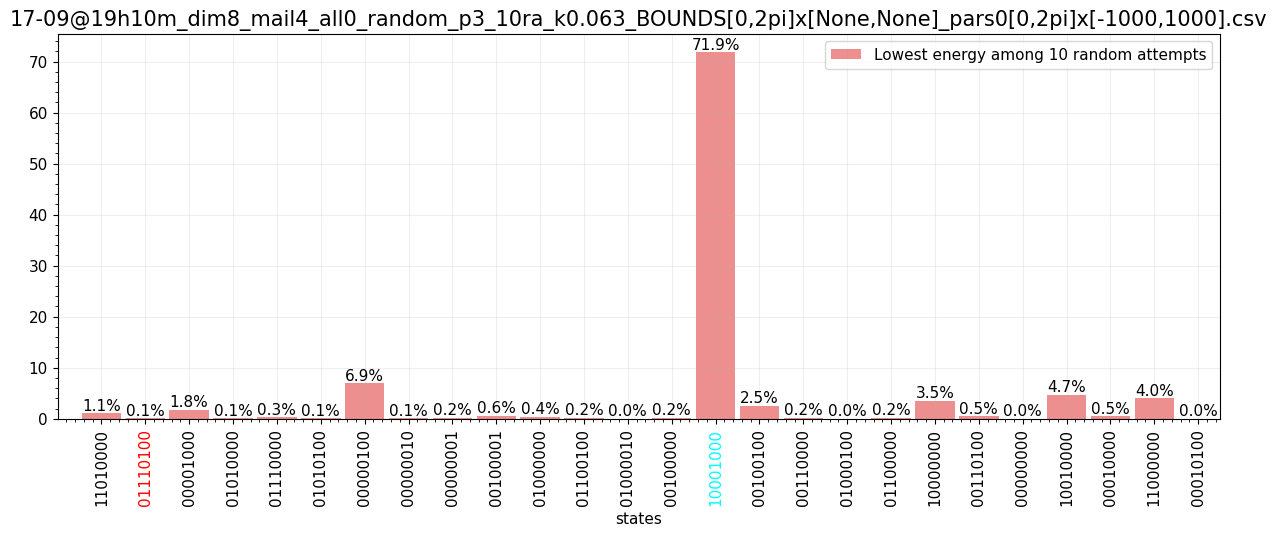

In [35]:
df = pd.read_csv(FILENAME, dtype = str).set_index('states')
df = df.astype(float).fillna(0.0)


##### COMPUTE PERCENTAGES AND ADD AVERAGE COLUMN
total = df.sum()
percentage = (df/ total) * 100

##### FIND THE BEST HISTOGRAM INDEX (i_best) BASED ON THE MINIMUM ENERGY FOUND
with open(DATA_FILENAME, 'r') as DATA_FILE:
    for line in DATA_FILE:
        if 'Attempt that reached the best result with' in line:                
            string = line.split('#')[1]
            i_best = string.split(' \n')[0]
            print("string", string)
            print("i_best is", i_best)
            
##### THE COLUMN CORRESPONDING TO THE BEST RESULT
column_best = f'counts_p{p}_{i_best}of{random_attempts}'

##### FIGURE
N=11
plt.figure(figsize=(15,5))
ax = sns.barplot(x="states", y=column_best, data=percentage, width=0.9, color='red', alpha=0.5, 
            label=f"Lowest energy among {random_attempts} random attempts")

# Make labels with percentages.
labels = percentage[column_best].round(1).astype('str') + '%'
for container in ax.containers:
        ax.bar_label(container, labels=labels, fontsize=N)
        
# Highlight exact covers' ticks with red.
highlight_correct_ticks(ax, percentage.index, EXACT_COVERS)

# Plot refinements.
plt.title(FILENAME, fontsize=N+4)
plt.xlabel("states", fontsize=N)
plt.ylabel("", fontsize=N)
plt.xticks(fontsize=N)
plt.yticks(fontsize=N)
plt.xlim(xmin=-1)
plt.ylim(ymin=0)
plt.minorticks_on()
plt.grid(alpha=0.2)
plt.legend(fontsize=N)
plt.show()

### Parameters fixing

In [36]:
max_p = 3
random_attempts = 10

In [37]:
# current_datetime = datetime.now().strftime("@%Y-%m-%d@%Hh%Mm%Ss")
current_datetime = datetime.now().strftime("%d-%m")

# This file will contain the final histograms.
header = f"{current_datetime}_dim{PROBLEM_DIM}_mail{instance}_{init_name}_maxp{max_p}_{random_attempts}ra_k{k}_BOUNDS[0,pi]x[0,2pi]"


# This file will contain important data such as energies, betas, gammas.
from ast import literal_eval
DATA_FILENAME = header + '_data.txt'
FILENAME = header + ".csv"

print(FILENAME, "\n", DATA_FILENAME)

17-09_dim8_mail4_all0_maxp3_10ra_k0.063_BOUNDS[0,pi]x[0,2pi].csv 
 17-09_dim8_mail4_all0_maxp3_10ra_k0.063_BOUNDS[0,pi]x[0,2pi]_data.txt


In [38]:
# p=3
# ansatz = QAOAAnsatz(qc_ham, mixer_operator=qc_mixing, initial_state=q_initial, reps=p, name='my_QAOA_circuit')

# # Generate a pass manager without providing a backend
# pm = generate_preset_pass_manager(optimization_level=3)
# ansatz_isa = pm.run(ansatz)
# hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

# estimator = StatevectorEstimator()
# sampler = StatevectorSampler()


# *******************************  MINIMIZE  **********************************
# # Do the minimization.

# pars_0 =  [np.pi * random.random(), np.pi * random.random(), 2 * np.pi * random.random(), 2 * np.pi * random.random()] 
    
# print('\nInitial parameters (for the minimization): pars_0 = ', pars_0)

# bnds = [(0, np.pi) for _ in range(p)] + [(0, 2*np.pi) for _ in range(p)]
# print("\nbnds", bnds)
# res = minimize(cost_func, pars_0, bounds=bnds,
#                args=(ansatz_isa, hamiltonian_isa, estimator), 
#                method="Nelder-Mead", options={"maxiter": 1000}, tol=1e-4)

# print("\nres", res)

# # Select the optimal parameters [beta,gamma] found.
# print("\nres.x", res.x)
# betas = list(res.x[:p])
# gammas = list(res.x[p:])
# print(f"Final parameters (after minimization): betas, gammas = {betas}, {gammas}")


# ****************************  RUN THE CIRCUIT  ******************************
# # Assign to the ansatz the 2p parameters found, then run the circuit.
# pars =[-1.54615350851878, 0.909773247370973, 1.784442449592837]+[-35.582930846019636, 51.45376690589117, 71.26888048656258]
# print("\npars", pars)
# qc = ansatz.assign_parameters(pars)
# qc.measure_all()
# qc.decompose(reps=2).draw('mpl')

# qc_isa = pm.run(qc)
# result = sampler.run([qc_isa], shots=1024).result()
# samp_dist = result[0].data.meas.get_counts()


# # ****************************  POST PROCESS  **********************************
# # Create a dataframe out of the sampling's results.
# df = pd.DataFrame(samp_dist.items()).rename(columns={0: 'states', 1: f'counts_p{p+1}'})
# df['states'] = df['states'].apply(lambda x: x[NUM_ANC:]) # remove ancillary bits
# df = df.groupby(['states']).sum()

# # Create a dictionary with states and occurrences.
# d = df[f'counts_p{p+1}'].to_dict()
# lists = sorted(d.items(), key=lambda item: item[1], reverse=True)

# # Invert bit order ("01101 -> 10110")      
# d = invert_counts(d)


# # **************************** PLOT THE i-TH DATAFRAME ****************************
# plt.figure(figsize=(15,5))
# plt.rcParams['font.size'] = 13
# plt.title(f"Ansatz with p={p}")
# df = pd.DataFrame(d.items())
# df = df.rename(columns={0: 'states', 1: f'counts_p{p}'})    
# df = df.sort_values(f'counts_p{p}', ascending=False) 

# ax = sns.barplot(x='states', y=f'counts_p{p}', data=df)

# # Make labels with percentages.
# labels = df[f'counts_p{p}'].apply(lambda x: (x/df[f'counts_p{p}'].sum())*100).round(1).astype('str') + '%'
# for container in ax.containers:
#     ax.bar_label(container, labels=labels, fontsize=11)
    
# # Highlight with red the exact covers
# highlight_correct_ticks(ax, df, EXACT_COVERS)
# plt.show()

In [39]:
# ansatz = QAOAAnsatz(qc_ham, mixer_operator=qc_mixing, initial_state=q_initial, reps=p, name='my_QAOA_circuit')
# ansatz.parameter_bounds=[[0, 2*np.pi], None]
# print(ansatz.parameter_bounds)

In [40]:
with open(DATA_FILENAME, 'a') as DATA_FILE:
    DATA_FILE.write(f"The initial state is an equal superposition of: {init_state} \n")
    
    DATA_FILE.write(f"max_p={max_p}\n")

    Energies = []
    
    TOTAL_start_time = time.time()
    DATA_FILE.write(f"Random attempts for each layer: {random_attempts}\n")
    
    for p in range(1, max_p+1):
        
        print(f"\n **** p = {p} **** ")
        pth_start_time = time.time()
        E_best = 100
        counter = 0
    
        
        Energies_of_layer_p = []
        
        for i in range(random_attempts):
            print(f"-------------{i}/{random_attempts}-----------------")
            ansatz = QAOAAnsatz(qc_ham, mixer_operator=qc_mixing, initial_state=q_initial, reps=p, name='my_QAOA_circuit')
            ###############
            ansatz.parameter_bounds=[(0, np.pi)]*p + [(0, 2*np.pi)]*p
            
            # Generate a pass manager without providing a backend
            pm = generate_preset_pass_manager(optimization_level=3)
            ansatz_isa = pm.run(ansatz)
            hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
        
            estimator = StatevectorEstimator()
            sampler = StatevectorSampler()
    
            
            # *******************************  MINIMIZE  **********************************
            # Do the minimization.
            ###############
            if p == 1:
                pars_0 = [np.pi * random.random(), 2 * np.pi * random.random()]
                bnds = [(0, np.pi), (0, 2*np.pi)]
            else:
                pars_0 =  pth_betas + [np.pi * random.random()] + pth_gammas + [2 * np.pi * random.random()] 
                bnds = [(0, np.pi)]*p + [(0, 2*np.pi)]*p
    
                
            print('Initial parameters (for the minimization): pars_0 = ', pars_0)
            ###############
            # bnds = [(0, np.pi) for _ in range(p)] + [(0, 2*np.pi) for _ in range(p)]
            # bnds = [(0, 2*np.pi)] * p + list(np.empty(p, dtype=object))
            print(bnds)
            res = minimize(cost_func, pars_0, bounds=bnds,
                           args=(ansatz_isa, hamiltonian_isa, estimator), 
                           method="Nelder-Mead", options={"maxiter": 1000}, tol=1e-4)
        
            
            # Select the optimal parameters [beta,gamma] found.
            betas = list(res.x[:p])
            gammas = list(res.x[p:])
            print(f"Final parameters (after minimization): betas, gammas = {betas}, {gammas}")
    
            
            # ****************************  RUN THE CIRCUIT  ******************************
            # Assign to the ansatz the 2p parameters found, then run the circuit.
            pars = betas + gammas
            qc = ansatz.assign_parameters(pars)
            qc.measure_all()
            qc_isa = pm.run(qc)
            result = sampler.run([qc_isa], shots=1024).result()
            samp_dist = result[0].data.meas.get_counts()
    
            
            # ****************************  POST PROCESS  **********************************
            # Create a dataframe out of the sampling's results.
            df = pd.DataFrame(samp_dist.items()).rename(columns={0: 'states', 1: f'counts_p{p+1}'})
            df['states'] = df['states'].apply(lambda x: x[NUM_ANC:]) # remove ancillary bits
            df = df.groupby(['states']).sum()
            
            # Create a dictionary with states and occurrences.
            d = df[f'counts_p{p+1}'].to_dict()
            lists = sorted(d.items(), key=lambda item: item[1], reverse=True)
        
            # Invert bit order ("01101 -> 10110")      
            d = invert_counts(d)
    
        
            # **************************** PLOT THE i-TH DATAFRAME ****************************
            plt.figure(figsize=(15,5))
            plt.rcParams['font.size'] = 13
            plt.title(f"Ansatz with p={p} iteration {i}/{random_attempts}")
            df = pd.DataFrame(d.items())
            df = df.rename(columns={0: 'states', 1: f'counts_p{p}'})    
            df = df.sort_values(f'counts_p{p}', ascending=False) 
            
            ax = sns.barplot(x='states', y=f'counts_p{p}', data=df)
            
            # Make labels with percentages.
            labels = df[f'counts_p{p}'].apply(lambda x: (x/df[f'counts_p{p}'].sum())*100).round(1).astype('str') + '%'
            for container in ax.containers:
                ax.bar_label(container, labels=labels, fontsize=11)
                
            # Highlight with red the exact covers
            highlight_correct_ticks(ax, df["states"], EXACT_COVERS)
            plt.show()
            
            # ******************* UPDATE PARAMETERS IF ENERGY HAS DECREASED *******************
            E_min = res.fun
            print(f"E_min - A - B = {E_min-A-B}")
            Energies_of_layer_p.append(E_min-A-B)
            
            if E_min < E_best:
                print("...UPDATING...")
                E_best = E_min
                d_best = d
                betas_best = betas
                gammas_best = gammas
    
            if df['states'].iloc[0] == MEC:
                print("### Most frequent state is MEC ###")
                counter += 1
            # if compute_energy_Lucas(df['states'].iloc[0], U, subsets_dict) == 0:
            #     print("### Most frequent state is an EC ###")
            #     counter += 1
            #     if df[f'counts_p{p}'].iloc[0] == 1024:
            #         print("-- BREAKING CYCLE - EXACT COVER FOUND --")
            #         break
                    
            # *********************************************************************************
    
        Energies.append(Energies_of_layer_p)
        DATA_FILE.write(f"\n----- p = {p} layer -----\nMinimum energy found in each attempt: ")
        DATA_FILE.write(str(Energies_of_layer_p))
        
        ################### PLOT THE p-TH DATAFRAME ###################
        # Plot the dataframe.
        plt.figure(figsize=(15,5))
        plt.rcParams['font.size'] = 13
        plt.title(f"Best parameters' ansatz with p={p}")
        df = pd.DataFrame(d_best.items())
        df = df.fillna(0)
        df = df.rename(columns={0: 'states', 1: f'counts_p{p}'})    
        df = df.sort_values(f'counts_p{p}', ascending=False)
        ax = sns.barplot(x='states', y=f'counts_p{p}', data=df, color='red')
    
        # Make labels with percentages.
        labels = df[f'counts_p{p}'].apply(lambda x: (x/df[f'counts_p{p}'].sum())*100).round(1).astype('str') + '%'
        for container in ax.containers:
            ax.bar_label(container, labels=labels, fontsize=11)
        
        highlight_correct_ticks(ax, df["states"], EXACT_COVERS)
        plt.show()
    
        # ################### SAVE TO CSV AND FIX BETA,GAMMA ###################
        # Save to csv.
        df.to_csv(FILENAME + f"_p{p}.csv", index=False)

        print(f"E_best - A - B = {E_best - A - B}")
        DATA_FILE.write(f"\nE_best = {E_best - A - B}")
        
        # Best parameters'vector of length 2p found for the p-th cycle
        pth_betas = betas_best
        pth_gammas = gammas_best
        print(f'\nBEST PARAMETERS OF p={p} LAYER: betas, gammas = ', pth_betas, pth_gammas)
        DATA_FILE.write(f'\nE_best\'s parameters: betas = {pth_betas}, gammas = {pth_gammas}\n')
        
        print("Execution time of p={0} layer: {1:.1f} min".format(p, (time.time() - pth_start_time)/60))
        DATA_FILE.write("Execution time of p={0} layer: {1:.1f} min\n".format(p, (time.time() - pth_start_time)/60))
        print(f"Most frequent state was MEC / random attempts = {counter} / {random_attempts}") 
        DATA_FILE.write(f"Most frequent state was MEC / random attempts = {counter} / {random_attempts} = {round((counter/random_attempts)*100, 1)}%\n")
    
        # Merge dataframes.
        if p == 1:
            df_final = df
        else:
            df_final = pd.merge(df_final, df, on="states", how="outer")    
    
        
    # ************************ SEE FINAL RESULT ************************
    # Plot all the dataframes in one picture.
    plt.figure()
    plt.rcParams['font.size'] = 13
    df_final = df_final.fillna(0)
    df_final.plot(x='states', kind="bar", figsize=(20,5), stacked=False)
    
    # Make labels with percentages.
    ax1 = plt.gca()
    ax1.set_ylabel("counts")
    for i,container in enumerate(ax1.containers):
        p = i+1
        labels = df_final[f'counts_p{p}'].apply(lambda x: (x/df_final[f'counts_p{p}'].sum())*100).round(1).astype('str') + '%'
        ax1.bar_label(container, labels=labels)
    highlight_correct_ticks(plt.gca(), df_final["states"], EXACT_COVERS)
    
    
    ######################################################################
    print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")
    DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.\n")

NameError: name 'init_state' is not defined

In [113]:
print(p)
ansatz.parameter_bounds

2


[(0, 3.141592653589793),
 (0, 3.141592653589793),
 (0, 6.283185307179586),
 (0, 6.283185307179586)]

#### Energia minima al variare di p

In [ ]:
"""
Questo è il grafico di quello che su Lee (2021) viene chiamato "mean approximation ratio".
Non credo che però in questo problema abbia senso. L'energia potrebbe diminuire anche nel 
caso in cui finisse in un minimo locale, se il minimo locale ha energia abbastanza bassa.
"""

E_mean = []
E_min = []
E_std = []
E_max = []

for Energies_of_layer_p in Energies:
    e = Energies_of_layer_p
    print(e)
    E_mean.append(np.mean(e))
    E_min.append(np.min(e))
    E_std.append(np.std(e))
    E_max.append(np.max(e))

plt.figure()
plt.grid()
plt.xlabel("p")
plt.ylabel(f"Mean over {random_attempts} mean energies")
p = np.array([str(i+1) for i in np.arange(len(Energies))])
plt.errorbar(x=p, y=E_mean, yerr=E_std, 
             elinewidth=3, capsize=5, barsabove=True, color = 'black', fmt ='o')
plt.plot(p, E_min, color = 'red', linestyle='--', marker="o", label='Minimum values')
plt.plot(p, E_max, color = 'blue', linestyle='--', marker="o", label='Maximum values')

plt.ylim(-1,-0.95)
plt.legend(loc="best")
print("\n E_min = ", E_min)

### Parameters fixing (read from file)

In [45]:
# ############# DIM 6 #############
all_instances = {
1: [{4, 6, 7, 9, 10, 11}, {1, 2, 5, 6, 11, 12}, {8, 1, 12}, {2, 3, 5}, {1, 3, 4, 5, 9, 12}, {2, 6, 7, 9, 12}] ,
2: [{2, 11, 12, 6}, {2, 4, 6, 8, 9, 11}, {1, 3, 5, 7, 10, 12}, {2, 7}, {2, 3, 4, 5, 8, 12}, {1, 2, 8, 9, 12}] ,
3: [{8, 10, 3}, {2, 4, 5, 6, 9, 11, 12}, {1, 3, 7, 8, 10}, {3, 4, 6, 8, 11}, {2, 3, 4, 6, 7, 9, 12}, {1, 7}] ,
4: [{1, 4, 5, 6, 8, 11, 12}, {3, 6, 8, 9, 10}, {1, 2, 11, 5}, {2,3, 7, 9,10}, {8, 3, 12, 6}, {4, 7, 12}] ,
5: [{11, 7}, {1, 2, 4, 5, 9, 11}, {1, 3, 4, 6, 8}, {2, 5}, {3, 6, 7, 8,10, 12}, {9, 10, 12}] ,
6: [{2, 3, 4, 5, 7, 8,9, 10, 11, 12}, {5, 9, 10, 11}, {3, 6, 7, 8}, {1, 2, 4, 12}, {1, 6}, {2, 3, 4, 7, 8, 12}] ,
7: [{1, 2, 5, 6, 7, 9, 12}, {10, 3, 4}, {2, 5, 7, 8, 9, 10, 11}, {8, 11}, {1, 7, 8, 11, 12}, {11, 9, 3, 7}] ,
8: [{1, 2, 4, 5, 6, 8, 9, 10}, {1, 4, 6, 7}, { 5, 8, 9, 11, 12}, {4, 7, 8, 9, 10, 11, 12}, {2, 3, 4, 5, 6, 7, 11, 12}, {10, 2, 3}] ,
9: [{1, 4, 7, 9, 10, 11, 12}, {2, 3, 5, 6, 8}, {1, 2, 4, 9, 12}, {2,3, 6, 7, 8, 9}, {1, 4, 6, 7, 8, 10, 11}, {8, 11, 3, 6}] ,
10: [{1, 11, 12, 6}, {2, 5, 8, 10, 11, 12}, {2, 6, 7, 8, 9, 10, 11}, {2, 3,4, 5, 7, 8, 9, 10}, {1, 2, 4, 5, 6, 7, 8, 11}, {1, 5, 6, 9, 10, 11, 12}]} 

# ########### DIM 8 ###########
# all_instances = { 
# 1: [{1, 2, 3, 4, 7, 8, 9, 12, 13, 14}, {1, 4, 5, 8, 9, 12, 13, 14, 16}, {1, 6, 9, 10, 11, 13, 15, 16}, {5, 6, 10, 11, 15, 16}, {1, 6, 7, 8, 9, 10, 14, 15}, {8, 13, 4, 12}, {2, 3, 4, 5, 7, 8, 11, 12, 13}, {4, 5, 6, 7, 10, 12, 14, 16}],
# 2: [{1, 2, 3, 5,7,12, 15}, {6, 7, 8, 9}, {4, 6, 8, 9, 10, 11, 13, 14, 16}, {3, 4, 5, 6, 7, 9, 10, 11, 12, 15}, {4, 12, 14}, {2, 3, 7, 8, 10, 15}, {1, 4, 6, 8, 9, 10, 12, 14, 15}, {1, 2, 3, 5, 10, 11,13, 15, 16}],
# 3: [{4, 7, 14, 15,16}, { 4, 5, 8, 9, 10, 13, 14, 16}, {1, 3, 4, 6, 8, 9, 10, 12, 13, 14}, {1, 3, 5, 6, 10}, {2, 4, 6, 9, 10, 11, 15}, {1, 2, 4, 5, 9, 13, 14, 15}, {1, 2, 3, 6, 7, 11, 12, 15}, {2, 8, 9, 11, 12, 13}], 
# 4: [{2, 4, 5, 6, 9}, {13, 14, 15, 16}, {1, 4, 5, 6}, { 7, 8, 10, 12}, {1, 3, 7, 8, 10, 11, 12, 13, 14, 15, 16}, {2, 3, 9, 11}, {3, 4, 5, 7, 8, 10, 12}, {3, 7, 8, 9, 10, 11, 14}],
# 5: [{5, 8, 10, 11, 12, 13, 16}, {1, 2, 3, 4, 6, 7, 9, 14, 15}, {1, 2, 5, 7, 8, 9, 10, 11, 12, 13, 15, 16}, {3, 4, 9, 11, 13, 14, 16}, {2, 3, 6, 10, 13, 16}, {1, 3, 8, 10, 11, 13,14, 15}, {1, 6, 8, 10, 11, 13, 14, 16}, {3, 4, 7, 10, 11, 13, 14, 15, 16}],
# 6: [{1, 2, 5, 6, 7, 10, 12, 15}, {5, 6, 9, 10}, {2, 7, 11, 12}, {3, 6, 7, 8, 9, 12, 15, 16}, {1, 3, 4, 8, 13, 14, 15, 16}, {2, 3, 6, 7, 8, 10, 15, 16}, {1, 2, 3, 4, 7, 8, 12, 13, 14}, {2, 3, 8, 11, 12, 14}],
# 7: [{2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15}, {2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16}, {10, 11, 15, 7}, {2, 3, 9, 10, 11, 14, 16}, {1, 2, 7, 10, 11, 12, 13, 14, 15}, {1, 4, 9, 14, 16}, {3, 4, 5, 9, 11, 12, 14, 16}, {2, 7, 9, 10, 11, 12, 13, 14, 15, 16}],
# 8: [{1, 4, 8, 9, 10, 13, 14, 15, 16}, {1, 2, 4, 5, 6, 7, 9, 12, 13}, {2, 3, 5, 6, 7, 11, 12}, { 5, 11, 12}, {1, 2, 3, 7, 8, 10, 11, 13}, {1, 2, 4, 7, 8, 13, 14, 15, 16}, {2, 3, 6, 7}, {1, 3, 4, 6, 9, 11, 12, 14, 16}],
# 9: [{2, 4, 14,15}, {1, 3, 6, 8}, {5, 7, 10, 13, 16}, {1, 2, 4, 6, 7, 10, 11, 13, 15, 16}, {4, 6, 7, 11, 12, 13, 15}, {3, 5, 8, 9, 12, 14}, {9, 11, 12}, {2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16}],
# 10: [{2, 3, 5, 6, 7, 8, 9, 11, 13, 16}, {1, 4, 5, 7, 9, 12, 14}, {6, 7, 11, 13, 14, 15, 16}, {6, 7, 8, 9, 11, 15, 16}, {2, 5, 10, 12, 14}, {1, 5, 6, 7, 11, 12, 14}, {2, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16}, {1, 3, 4, 13}]
# }

instance = 3

subsets_dict = dict([(k,v) for k,v in enumerate(all_instances[instance])])
PROBLEM_DIM = len(subsets_dict)

# Scelta l'istanza si può calcolare U.
U = find_U_from_subsets(subsets_dict)


print("subsets:\n", subsets_dict)
print("PROBLEM_DIM:\n", PROBLEM_DIM)
print("U:\n", U)




###############################

EXACT_COVERS = []
for nuple in bit_gen(PROBLEM_DIM):
    
    state = "".join([str(bit) for bit in nuple]) # strings
    E = compute_energy_Lucas(state, U, subsets_dict)
    if E == 0: EXACT_COVERS.append(state)

MECs = [state for i,state in enumerate(EXACT_COVERS) if state.count("1") == min([x.count("1") for x in EXACT_COVERS])]
print("MEC", MECs)

ECs = [elem for elem in EXACT_COVERS if elem!=MEC]
print("EC", ECs)


subsets:
 {0: {8, 10, 3}, 1: {2, 4, 5, 6, 9, 11, 12}, 2: {1, 3, 7, 8, 10}, 3: {3, 4, 6, 8, 11}, 4: {2, 3, 4, 6, 7, 9, 12}, 5: {1, 7}}
PROBLEM_DIM:
 6
U:
 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
MEC ['011000']
EC ['011000', '110001']


In [46]:
header = "11-09_dim6_mail3_all0_maxp3_10ra_k0.067_BOUNDS[0,pi]x[0,2pi]"
max_p = 3

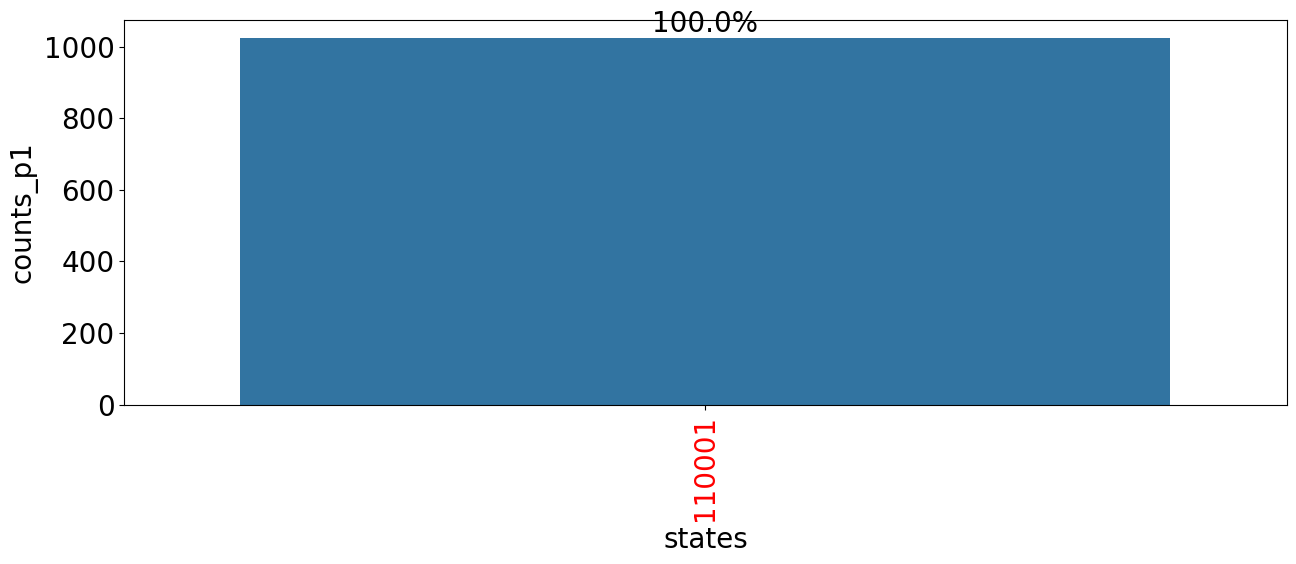

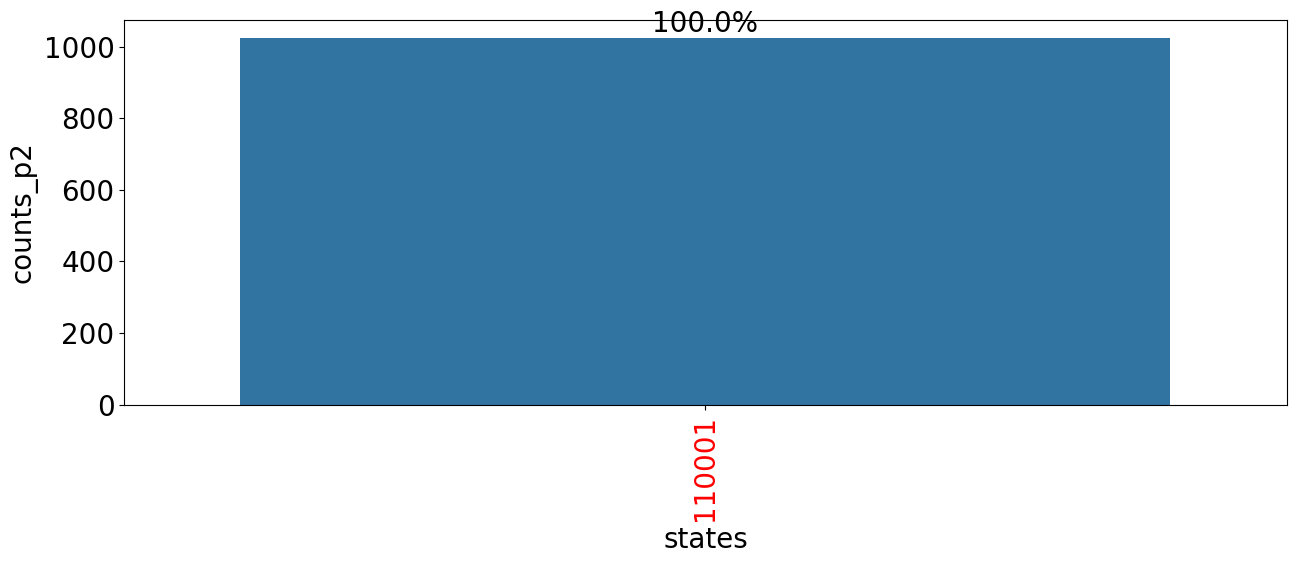

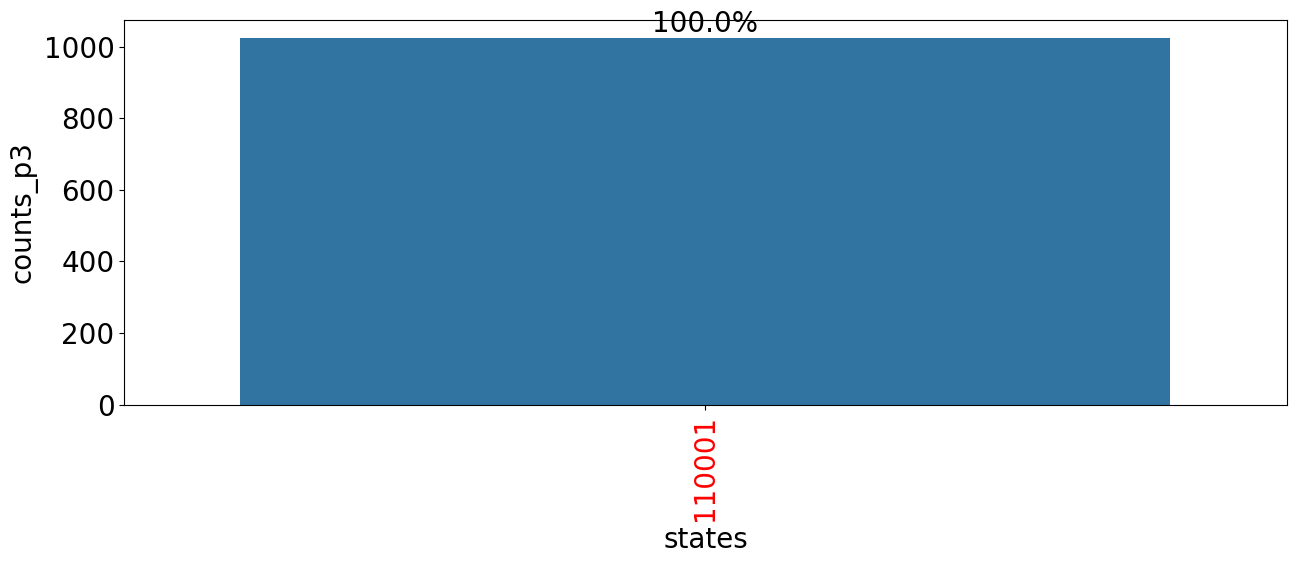

<Figure size 1500x500 with 0 Axes>

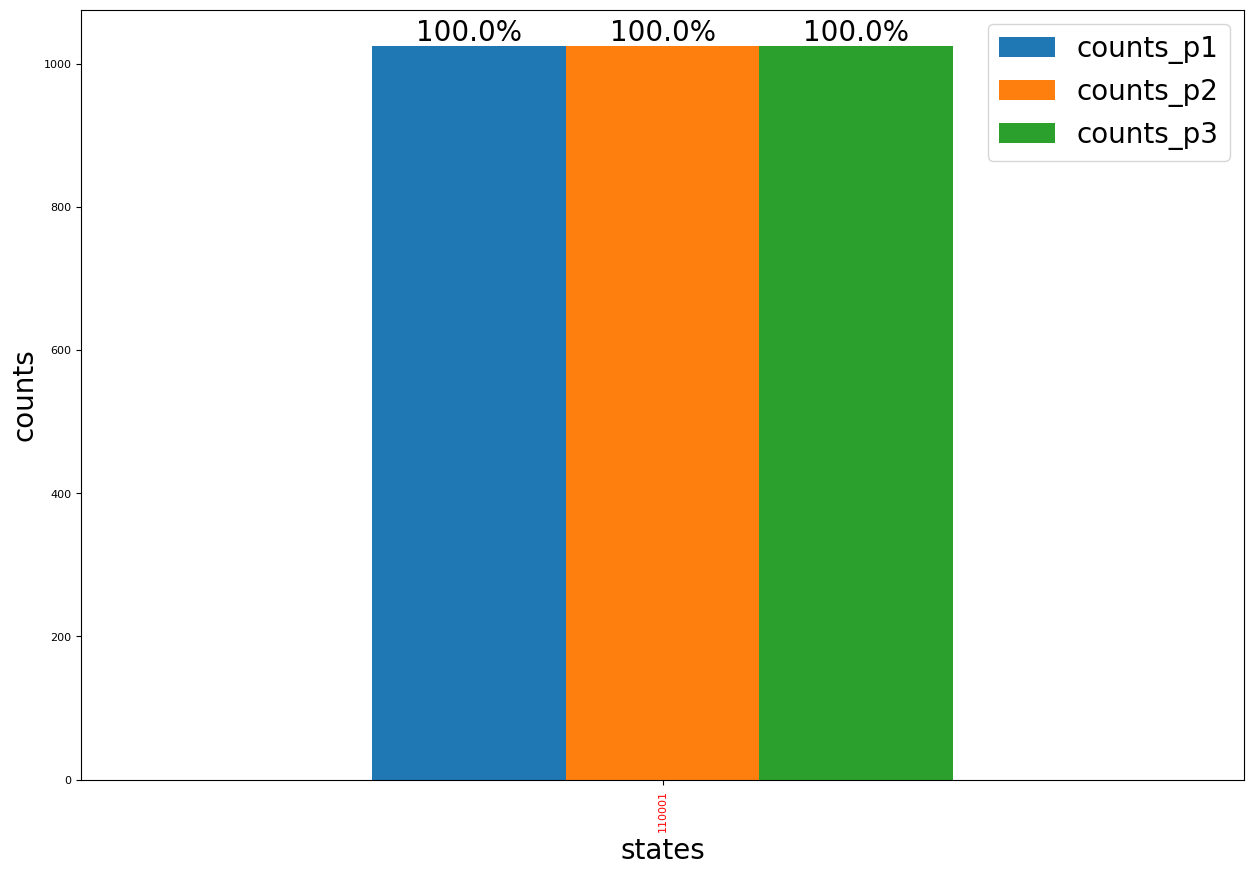

In [47]:
most_frequent_states = []
labels = []

for p in range(1, max_p+1):

    # Read from csv.
    file_to_read = header + f"_p{p}.csv"
    
    df = pd.read_csv(file_to_read, dtype = {'states':"str", f'counts_p{p}':"Int64"})
    most_frequent_states.append([df["states"].iloc[0], df[f'counts_p{p}'].iloc[0]])
    
    # Plot the dataframe.
    plt.figure(figsize=(15,5))
    df = df.sort_values(f'counts_p{p}', ascending=False)
    ax = sns.barplot(x='states', y=f'counts_p{p}', data=df)
    highlight_correct_ticks(ax, df["states"], EXACT_COVERS)
    
    # Make labels with percentages.
    labels.append(df[f'counts_p{p}'].apply(lambda x: (x/df[f'counts_p{p}'].sum())*100).round(1).astype('str') + '%')
    for container in ax.containers:
        ax.bar_label(container, labels=labels[p-1])
    plt.show()
    
    # Merge dataframes.
    if p == 1:
        df_final = df
    else:
        df_final = pd.merge(df_final, df, on="states", how="outer")    


# Plot all the dataframes in one picture.
plt.figure(figsize=(15,5))
df_final.plot(x='states', kind="bar", figsize=(15,10), fontsize=8, stacked=False)
df_final = df_final.fillna(0)

# Make labels with percentages.
ax1 = plt.gca()
ax1.set_ylabel("counts")
for i,container in enumerate(ax1.containers):
    p = i+1
    labels = df_final[f'counts_p{p}'].apply(lambda x: (x/df_final[f'counts_p{p}'].sum())*100).round(1).astype('str') + '%'
    ax1.bar_label(container, labels=labels)
highlight_correct_ticks(plt.gca(), df_final["states"], EXACT_COVERS)

In [40]:
df_final
ECs

['101101']

   states  counts_p1  counts_p2  counts_p3
0  110001       1024       1024       1024
0    True
Name: states, dtype: bool
   states  counts_p1  counts_p2  counts_p3
0  110001       1024       1024       1024
['110001']
110001


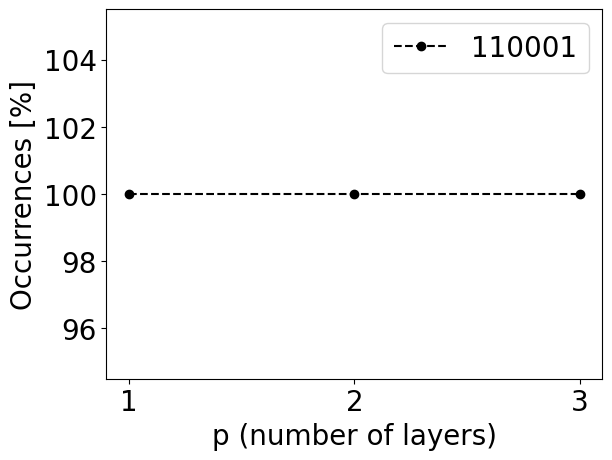

In [48]:
# Find the exact cover 
mask = df_final['states'].isin(ECs)
print(df_final.head())
print(mask)

df_exact_covers = df_final[mask]
print(df_exact_covers.head())
exact_covers = df_exact_covers["states"].values
print(exact_covers)
solution =  df_exact_covers["states"].iloc[0]
print(solution)
counts = df_exact_covers.iloc[0, 1:].values
layers = [str(i+1) for i in np.arange(max_p)]

# Plot the figure.
plt.figure()
total = 1024
plt.plot(layers, counts*100/total, linestyle='--', color='k', marker='o', label=f"{solution}")
plt.ylabel("Occurrences [%]")
plt.xlabel("p (number of layers)")
plt.legend()

plt.show()

[100.0, 100.0, 100.0] [True, True, True]


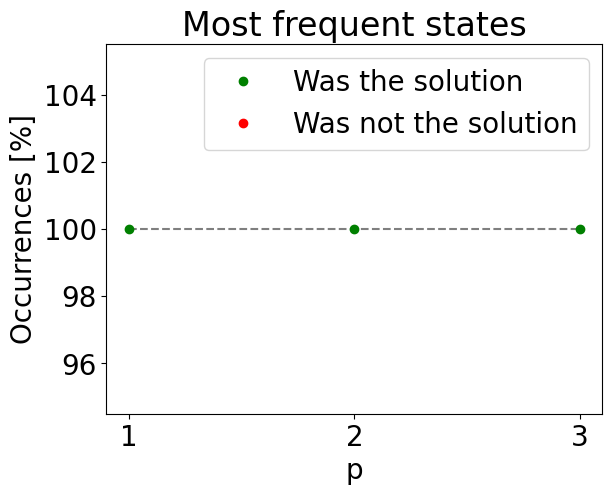

In [49]:
probs = []
mask = [] # True if the most frequent state is the correct state, False otherwise

total = 1024

for tup in most_frequent_states:
    state = tup[0]
    count = tup[1]
    if(state in ECs):
        mask.append(True)
    else:
        mask.append(False)
        
    probs.append(100 * count / total)

print(probs, mask)
mask = np.array(mask)
probs = np.array(probs)

# ********************* plot the figure *******************************
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

p = np.arange(1,max_p+1)
plt.errorbar(p[mask], probs[mask], fmt='o', color='g', label='Was the solution')
plt.errorbar(p[~mask], probs[~mask], fmt='o',  color='r', label='Was not the solution')
plt.plot(p, probs, linestyle='--', color='k', alpha = 0.5)

plt.ylabel("Occurrences [%]")
plt.xlabel("p")
plt.legend()
plt.title("Most frequent states")
plt.show()